# LTP - Lipid Transfer Proteins

LTP are proteins of great interest. This is not only due to their role in plant resistance and signaling againt pathogens but also due to their role in hypersensibilization. In different studies, it has been found in the serum of patients that are alergic to peach. PruP3, the best example of alergenic LTP has many interesting features: it is a 4 helix protein highly  stable, with low flexibility, resistance against heat and proteases, and it includes an internal tunnel inside the protein that allows to bind lipids in an non specific way. The release of the lipids is important in the hypersensibilization process, since the final receptor of those lipids (CTD) is directly implied in the recognision by NKT receptors mediating sensibilization.

<img src = './Figures/tunnel_A.png' alt = 'prup3-tunnelA' width=350>

In this notebook different aspects of PruP3 will be analyzed by using DM or other interesting methods.

In [1]:
import numpy as np
import prody as pdy
import json 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_palette('Set2')
sys.path.append('C:/Users/Bruno/Dropbox/LTP/pyprobing')
import pyproblib as pyprob
# sys.path.append('C:/Users/Bruno/Dropbox/UNIVERSIDAD/Master/Estructural/hydroPark/')
# from hydroUtils import hydroRead, hydroData



ModuleNotFoundError: No module named 'pyproblib'

# Study of Molecular Dynamics Trajectories

**Molecular dynamics** allow to integrate movement equations on the atomics coordinates of the molecules subjected to a force field including all representative forces in molecular interactions (electrostatics, dispersion, torsion, vibration, etc).

In this part, we'll analyze the output of 4 MD 100 ns simulations:
- Pru P 3 + phytosphingosine in orientation A
- Pru P 3 + sphingosine in orientation A
- Pru P 3 + phytosphingosine in orientation B
- Pru P 3 + sphingosine in orientation B

We'll perform analysis of RMSD trajectories, essential dynamics, free binding energies, and volume cavity.

## RMSD representation

The first step is to analyze the RMSD of the different trajectories.

In [3]:
folder_names = dict(
    prup3_lig_A = dict(mol='ligand', orientation = 'A'),
    prup3_lig_B = dict(mol='ligand', orientation = 'B'),
    prup3_ps_A = dict(mol='phytosphingosine', orientation = 'A'),
    prup3_ps_B = dict(mol='phytosphingosine', orientation = 'B'),
    prup3_s_A = dict(mol='sphingosine', orientation = 'A'),
    prup3_s_B = dict(mol='sphingosine', orientation = 'B')
)

In [9]:
try : 
    del md_rmsd
except NameError:
    pass
try :
    del tmp_protein
except NameError:
    pass
try :
    del tmp_ligand
except NameError:
    pass
for i in folder_names.keys():
    tmp_protein = pd.read_table(
        'F:/DM/run1/%s/rmsd_protein.dat' % i, sep = '\s', 
        names=['frame', 'RMSD'], engine='python' 
    )
    tmp_ligand = pd.read_table(
        'F:/DM/run1/%s/rmsd_ligand.dat' % i, sep = '\s', 
        names=['frame', 'RMSD'], engine='python'
    )
    tmp_complex = pd.read_table(
        'F:/DM/run1/%s/rmsd_complex.dat' % i, sep ="\s+",
        names=['frame', 'RMSD'], engine='python'
    )
    tmp_protein['entity'] = 'protein'
    tmp_ligand['entity'] = 'ligand'
    tmp_complex['entity'] = 'complex'
    tmp_protein['molecule'] = folder_names[i]['mol']
    tmp_ligand['molecule'] = folder_names[i]['mol']
    tmp_complex['molecule'] = folder_names[i]['mol']
    tmp_protein['orientation'] = folder_names[i]['orientation']
    tmp_ligand['orientation'] = folder_names[i]['orientation']
    tmp_complex['orientation'] = folder_names[i]['orientation']
    
    try :
        md_rmsd = pd.concat((md_rmsd, tmp_protein))
        md_rmsd = pd.concat((md_rmsd, tmp_ligand))
        #md_rmsd = pd.concat((md_rmsd, tmp_complex))
    except NameError:
        md_rmsd = pd.concat((tmp_protein, tmp_ligand))
        #md_rmsd = pd.concat((md_rmsd, tmp_complex))
md_rmsd[:10]

,frame,RMSD,entity,molecule,orientation
0,1,0.940139,protein,ligand,A
1,2,1.070266,protein,ligand,A
2,3,0.953977,protein,ligand,A
3,4,1.021407,protein,ligand,A
4,5,1.421372,protein,ligand,A
5,6,1.332557,protein,ligand,A
6,7,1.213960,protein,ligand,A
7,8,1.076643,protein,ligand,A
8,9,1.112370,protein,ligand,A
9,10,1.134303,protein,ligand,A


In [10]:
md_rmsd['time'] = 40000.0 * md_rmsd['frame'] / (1e6)

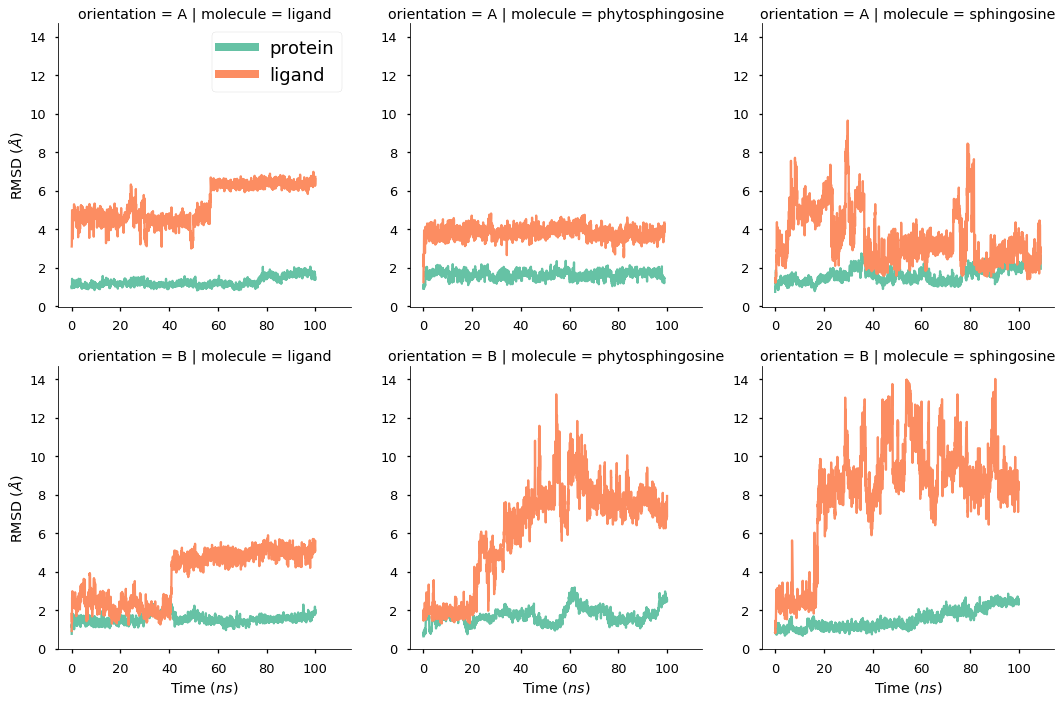

In [16]:
g = sns.FacetGrid(hue = 'entity', col='molecule', row='orientation', data= md_rmsd, size=5)

g.map(plt.plot, 'time', 'RMSD', alpha = 1.0)
g.set_xlabels('Time $(ns)$')
g.set_ylabels('RMSD $(\AA)$')
leg = g.axes[0,0].legend(framealpha=None, fontsize = 18)
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figure2.png', dpi=300)
plt.show()

Very important differences can be observed between trajectories.
- The PS in orientation A shows a boring trajectory, with no important oscillations nor translations nor rotations. It must be stable.
- The PS in orientation B shows a more interesting trajectory. The ligand moves from its original position, and it tries to scape in one ocassion, around the 60 ns.
- The S in orientation A shows a very irregular trajectory, it moves all the time, it tries to scape in several ocassions, although it does not.
- The ligand has also a boring trajectory, with a unique event of torsion of one of the angles.

## Representation of Free Binding Energy

I will input manually data from carma entropy calculations and CaFe free binding energy calculations.

In [3]:
import pandas as pd
prot = ['prup3_ps_A', 'prup3_s_A', 'prup3_ps_B', 'prup3_lig_A', 'prup3_lig_B', 'prup3_s_B']
molecule = ['phytosphingosine', 'sphingosine', 'phytosphingosine', 'ligand', 'ligand', 'sphingosine']
orientation = ['A', 'A', 'B', 'A', 'B', 'B']
entropy_complex = [222.57,235.47,233.72,219.21,219.65,231.02]
entropy_ligand  = [171.18,189.84,181.91,162.28,174.22,175.67]
entropy_protein = [222.06,231.23,232.06,218.34,218.82,228.11]
free_complex    = [-2678.46,-2691.97,-2663.59,-2626.24,-2617.98,-2672.95]
free_protein    = [-2678.31,-2679.82,-2669.70,-2673.48,-2664.05,-2657.98]
free_ligand    = [21.01,7.15,22.0915,67.27,69.41,7.71]

binding_energies = pd.DataFrame.from_items([
    ('name', prot),
    ('molecule', molecule),
    ('orientation', orientation),
    ('S_complex', entropy_complex),
    ('S_ligand', entropy_ligand),
    ('S_protein', entropy_protein),
    ('H_complex', free_complex),
    ('H_ligand', free_ligand),
    ('H_protein', free_protein),
])
binding_energies['temperature'] = 298
jul2kcal=0.000239006
binding_energies['delta_S'] = binding_energies['S_complex'] - (
    binding_energies['S_ligand'] + binding_energies['S_protein']
)
binding_energies['delta_S_kcal'] = binding_energies['temperature']*jul2kcal*binding_energies['delta_S']

binding_energies['delta_H'] = binding_energies['H_complex'] - (
    binding_energies['H_ligand'] + binding_energies['H_protein']
)
binding_energies['total'] = binding_energies['delta_H'] - (
    binding_energies['temperature'] * jul2kcal * binding_energies['delta_S'])

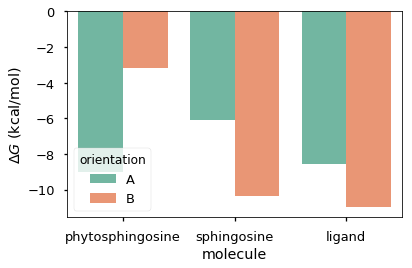

In [3]:
ax = sns.barplot(x = 'molecule', y ='total', data = binding_energies, hue ='orientation')
ax.set_ylabel('$\Delta G$ (kcal/mol)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/Figures/free_binding_energy.png', dpi=300)

plt.show()

Interesting. The phytosphingosine shows a higher energy than the sphingosine, which could have been expected from observing the trajectories, and the orientation A shows also a lower energy than orientation B. However, ligand is more stable than the other two, and it is more stable in orientation B, contradicting what we could have expected.

In [4]:
binding_energies[['name', 'delta_H', 'delta_S', 'delta_S_kcal','total']]

,name,delta_H,delta_S,delta_S_kcal,total
0,prup3_ps_A,-21.1600,-170.67,-12.155764,-9.004236
1,prup3_s_A,-19.3000,-185.60,-13.219135,-6.080865
2,prup3_ps_B,-15.9815,-180.25,-12.838088,-3.143412
3,prup3_lig_A,-20.0300,-161.41,-11.496232,-8.533768
4,prup3_lig_B,-23.3400,-173.39,-12.349493,-10.990507
5,prup3_s_B,-22.6800,-172.76,-12.304622,-10.375378


## Analysis of essential dynamics

I like essential dynamics because the show you the ways in which the ligand moves without having to observe the whole trajectory, and because it is possible to isolate those isolated movements with interesting events.

The fundaments of essential dynamics are those of PCA.
- Build covariance matrix for each of the coordinates of each of the studied particles (in this case, alpha carbons).
- Build a covariance matrix. $$ C = \frac{1}{n}XX^{T}$$
- Diagonalize this covariance matrix, and isolate the m eigenvectors associated to the highest eigenvalues ($P$).
- For each snapshot, make change the coordinate basis change to the base of $P$. $$Y=XP$$.

In [10]:
import prody as pdy
def get_esential_dynamics(dcd_name, psf_name, n_eigen = 3):
    psf = pdy.parsePSF(psf_name)
    dcd = pdy.DCDFile(dcd_name)
    dcd.link(psf)
    dcd.setAtoms(psf.calpha)
    traj = pdy.EDA(dcd_name.replace('.dcd', ''))
    traj.buildCovariance(dcd)
    traj.calcModes()
    P = traj[:n_eigen].getEigvecs()
    Y = np.zeros((dcd.numFrames(), n_eigen))
    i = 0
    for item in dcd:
        xx = item.getCoords()
        xx = xx.reshape((1, xx.size))
        Y[i,:] = xx.dot(P)
        i += 1
    var_explain= traj.getVariances() / traj.getVariances().sum()
    var_explain = np.sum(var_explain[:n_eigen])
    return Y, var_explain

In [11]:
eda_dict= dict(
    prup3_ps_A = dict(orientation = 'A', mol = 'phytosphingosine', traj = None, varexplained= 0),
    prup3_ps_B = dict(orientation = 'B', mol = 'phytosphingosine', traj = None, varexplained= 0),
    prup3_s_A  = dict(orientation = 'A', mol = 'sphingosine', traj = None, varexplained= 0),
    prup3_s_B  = dict(orientation = 'B', mol = 'sphingosine', traj = None, varexplained= 0)
)

In [12]:
for key in eda_dict.keys():
    trj, vr = get_esential_dynamics(
        'F:DM/run1/%s/%s_nwater_pbcsolved.dcd' % (key, key),
        'C:/Users/Bruno/Dropbox/LTP/MD/charmm/%s_charmm.psf' % key,
        3
    )
    eda_dict[key]['traj'] = trj
    eda_dict[key]['varexplained'] = vr

@> Covariance will be calculated using 2473 frames.
@> Covariance matrix calculated in 6.036934s.
@> 20 modes were calculated in 0.02s.
@> Covariance will be calculated using 2500 frames.
@> Covariance matrix calculated in 5.488374s.
@> 20 modes were calculated in 0.00s.
@> Covariance will be calculated using 2725 frames.
@> Covariance matrix calculated in 6.513150s.
@> 20 modes were calculated in 0.02s.
@> Covariance will be calculated using 2500 frames.
@> Covariance matrix calculated in 5.411766s.
@> 20 modes were calculated in 0.00s.


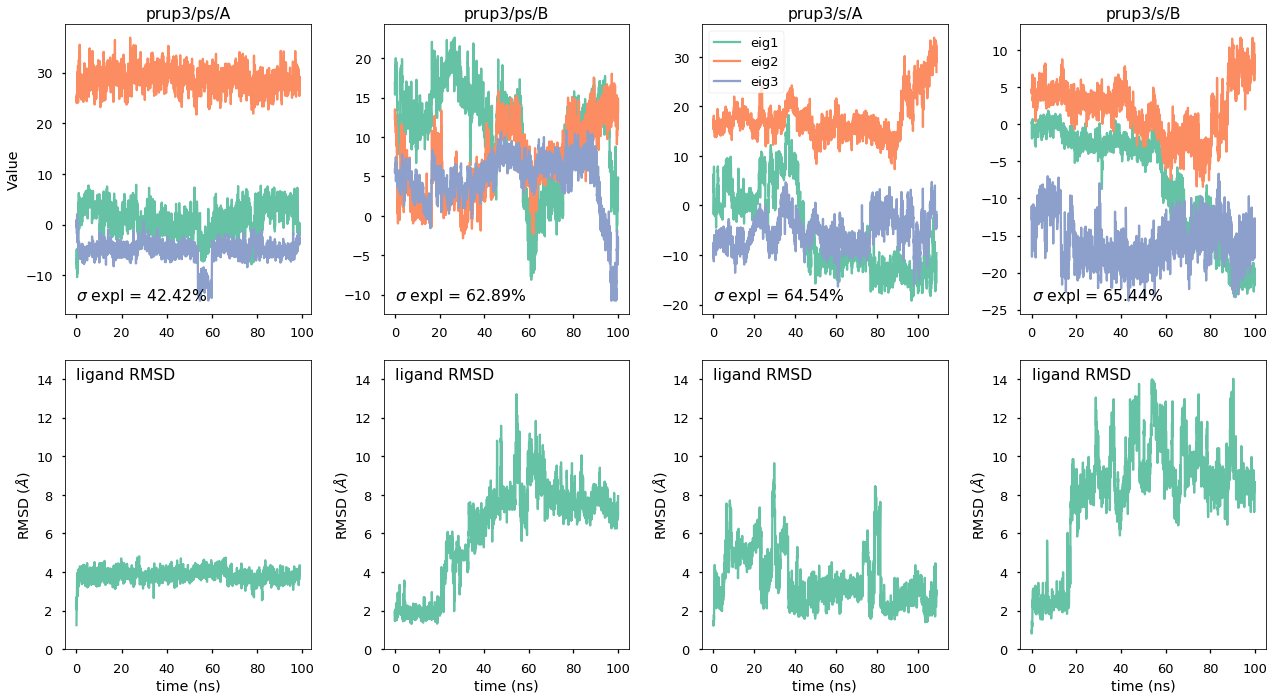

In [13]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(18,10)
i = 0
for key in eda_dict.keys():
    time = np.arange(len(eda_dict[key]['traj'][:,0])) *(4e-2)
    ax[0,i].set_title(key.replace('_', '/'))
    ax[0,i].plot(time, eda_dict[key]['traj'][:,0], label = 'eig1')
    ax[0,i].plot(time, eda_dict[key]['traj'][:,1], label = 'eig2')
    ax[0,i].plot(time, eda_dict[key]['traj'][:,2], label = 'eig3')
    mn = eda_dict[key]['traj'].min()
    if i == 0 :
        ax[0,i].set_ylabel('Value')
    ax[0, i].text(0, mn, "$\sigma$ expl = %3.2f" % (100 * eda_dict[key]['varexplained']) + "%")
    if i == 2:
        ax[0,i].legend()
    
    rmsd=md_rmsd.query(
        'molecule == "%s" and orientation == "%s" and entity =="ligand"' % (
            eda_dict[key]['mol'],
            eda_dict[key]['orientation']
        )
    )
    ax[1, i].plot(rmsd['time'], rmsd['RMSD'])
    ax[1, i].set_ylim(0,15)
    ax[1, i].set_xlabel('time (ns)')
    ax[1, i].set_ylabel('RMSD ($\AA$)')
    ax[1, i].text(0, 14, 'ligand RMSD')
    i += 1
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/Figures/MD_eda.png', dpi=300)

plt.show()

Again, it can be observed that Pru p 3/ps/A is the most boring trajectory and that it has the most boring modes, meanwhile in the orientation B we have mixed modes, and the seem to be quite correlated with the changes in ligand RMSD. The same holds for Pru p 3/s/A.

In [14]:
from scipy import stats
instance_list = []
comp_list = []
correlation = []
pval_list = []
for key in eda_dict.keys():
    rmsd = md_rmsd.query(
    'molecule == "%s" and orientation == "%s" and entity =="ligand"' % (eda_dict[key]['mol'],eda_dict[key]['orientation']))
    for i in [0, 1, 2]:
        r,p = stats.pearsonr(rmsd['RMSD'],eda_dict[key]['traj'][:,i][1:])
        correlation.append(r)
        instance_list.append(key)
        comp_list.append('component %d' % i)
        pval_list.append(p)
rmsd_corr = pd.DataFrame.from_items([
    ('instance', instance_list),
    ('component', comp_list),
    ('correlation', correlation),
    ('pvalue', pval_list)
])
rmsd_corr['instance'] = rmsd_corr['instance'].str.replace('_', '/')
rmsd_corr['instance'] = rmsd_corr['instance'].str.replace('prup3', 'pru p 3')
rmsd_corr

,instance,component,correlation,pvalue
0,pru p 3/ps/A,component 0,-0.089828,7.714657e-06
1,pru p 3/ps/A,component 1,-0.065959,1.033200e-03
2,pru p 3/ps/A,component 2,-0.264221,9.240604e-41
3,pru p 3/ps/B,component 0,-0.471577,1.409475e-138
4,pru p 3/ps/B,component 1,0.466064,5.575911e-135
5,pru p 3/ps/B,component 2,0.229024,4.234994e-31
6,pru p 3/s/A,component 0,0.409556,1.113407e-110
7,pru p 3/s/A,component 1,-0.126467,3.492705e-11
8,pru p 3/s/A,component 2,-0.063134,9.777930e-04
9,pru p 3/s/B,component 0,-0.355811,1.796347e-75


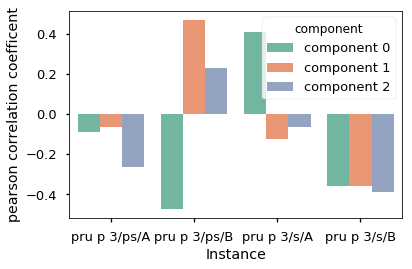

In [15]:
ax = sns.barplot(x= 'instance', y = 'correlation', data = rmsd_corr, hue = 'component')
ax.set_ylabel('pearson correlation coefficent')
ax.set_xlabel('Instance')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/Figures/correlation_modes_rmsd.png', dpi = 300)
plt.show()

As it could be noticed in the previous plot, there are interesting correlations between the modes of pru p 3/ps/B and pru p 3/s/A.

## Analysis of hydrogen bonds

In [22]:
for i in folder_names.keys():
    print(i)

prup3_ps_A
prup3_s_A
prup3_ps_B
prup3_lig_A
prup3_lig_B
prup3_s_B


In [23]:
try :
    del md_hb
except NameError:
    pass
for i in folder_names.keys():
    tmp = pd.read_table('F:/DM/run1/%s/hydrogen_bonds.dat' % i, 
                        names = ['frame','hb'], sep = '\s')
    tmp['orientation'] = folder_names[i]['orientation']
    tmp['molecule']    = folder_names[i]['mol']
    tmp['hb_softened'] = soften(tmp['hb'], 10)
    tmp['time'] = tmp['frame'] * (4e-2)
    try :
        md_hb = pd.concat((md_hb, tmp))
    except NameError :
        md_hb = tmp
md_hb[:10]

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,frame,hb,orientation,molecule,hb_softened,time
0,0,0,A,phytosphingosine,0.1,0.00
1,1,0,A,phytosphingosine,0.1,0.04
2,2,0,A,phytosphingosine,0.1,0.08
3,3,0,A,phytosphingosine,0.2,0.12
4,4,1,A,phytosphingosine,0.2,0.16
5,5,0,A,phytosphingosine,0.2,0.20
6,6,0,A,phytosphingosine,0.2,0.24
7,7,1,A,phytosphingosine,0.2,0.28
8,8,0,A,phytosphingosine,0.2,0.32
9,9,0,A,phytosphingosine,0.2,0.36


In [17]:
def soften(x, n):
    box = np.ones(n)/n
    x_smooth = np.convolve(x, box, mode='same')
    return x_smooth

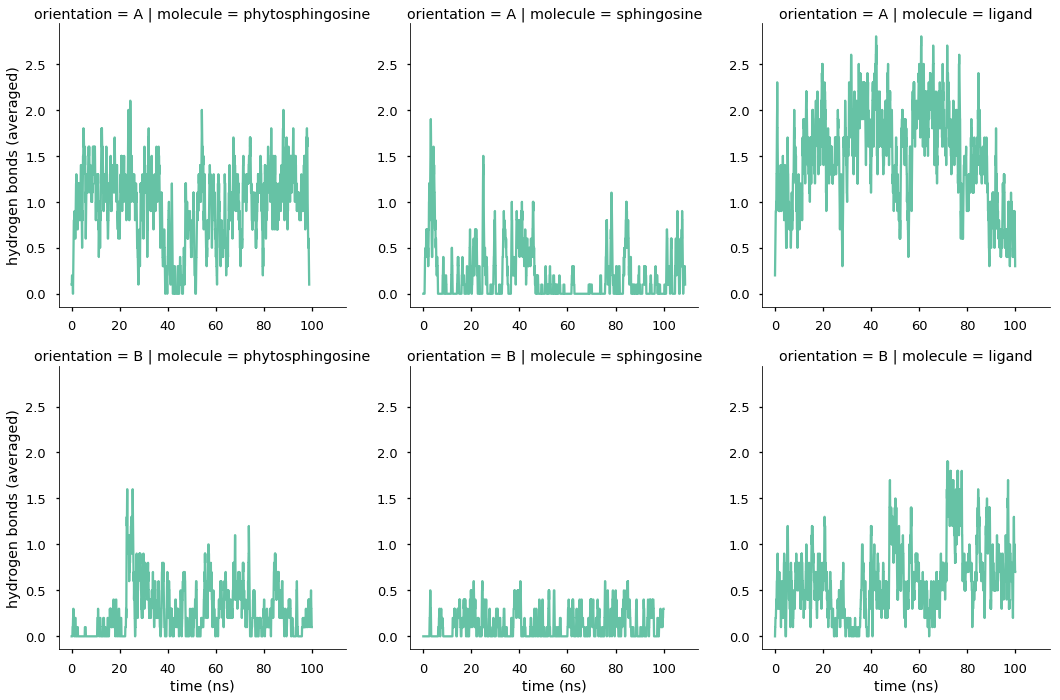

In [24]:
g = sns.FacetGrid(col = 'molecule', row = 'orientation', data = md_hb, size = 5)
g.map(plt.plot, 'time', 'hb_softened')
g.set_xlabels('time (ns)')
g.set_ylabels('hydrogen bonds (averaged)')
plt.savefig('C:/Users/Bruno/Dropbox/LTP/Figures/hydrogen_bonds.png', dpi = 300)
plt.show()

This plot shows the softened number of hydrogen bonds for each time step in the simulation. In general it can be observed that the orientation A has more hydrogen bonds, than the B, and that sphingosine forms very few hydrogen bonds across its trajectory.

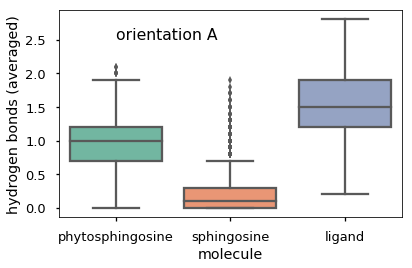

In [25]:
ax = sns.boxplot(x = 'molecule', y = 'hb_softened', data=md_hb.query('orientation == "A"'))
ax.set_ylabel('hydrogen bonds (averaged)')
ax.text(0,2.5, 'orientation A')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/Figures/boxplot_hb.png', dpi = 300)
plt.show()

The ligand and phytosphingosine show a a similar number of hydrogen bonds along trajectory, meanwhile sphingosine does not. All the boxes belong the orientation A in this plot.

## Analysis of cavities

Pru p 3 has as most interesting feature the fact that it has a tunel that allows the ligands to bind in two orientations. Analysing cavities can help to understand very important features of the system.

In [4]:
import prody as pdy

In [21]:
def make_pdb_list(fname, dcdname, psfname, span):
    dcd = pdy.DCDFile(dcdname)
    psf = pdy.parsePSF(psfname)
    dcd.link(psf)
    i = 0
    sorted_list = []
    for frame in dcd : 
        if i % span == 0 :
            print("[pdb list] writting frame %d to %s" % (i, fname) )
            pdy.writePDB(fname + '_%s' %(i) + '.pdb',  frame)
            sorted_list.append(fname + '_%s' %(i) + '.pdb')
        i += 1
    return sorted_list

In [22]:
folder_names['prup3_lig_A']['dcd'] = 'F:DM/run1/prup3_lig_A/prup3_lig_A_nwater_pbcsolved.dcd'
folder_names['prup3_lig_B']['dcd'] = 'F:DM/run1/prup3_lig_B/prup3_lig_B_nwater_pbcsolved.dcd'
folder_names['prup3_ps_A']['dcd'] = 'F:DM/run1/prup3_ps_A/prup3_ps_A_nwater_pbcsolved.dcd'
folder_names['prup3_ps_B']['dcd'] = 'F:DM/run1/prup3_ps_B/prup3_ps_B_nwater_pbcsolved.dcd'
folder_names['prup3_s_A']['dcd'] = 'F:DM/run1/prup3_s_A/prup3_s_A_nwater_pbcsolved.dcd'

folder_names['prup3_lig_A']['psf'] = 'F:DM/run1/prup3_lig_A/prup3_lig_A_charmm.psf'
folder_names['prup3_lig_B']['psf'] = 'F:DM/run1/prup3_lig_B/prup3_lig_B_charmm.psf'
folder_names['prup3_ps_A']['psf'] = 'F:DM/run1/prup3_ps_A/prup3_ps_A_charmm.psf'
folder_names['prup3_ps_B']['psf'] = 'F:DM/run1/prup3_ps_B/prup3_ps_B_charmm.psf'
folder_names['prup3_s_A']['psf'] = 'F:DM/run1/prup3_s_A/prup3_s_A_charmm.psf'


In [23]:
for item in folder_names.keys():
    savefolder = 'F:DM/run1/pdblists/%s/%s' % (item, item)
    slist = make_pdb_list(
        savefolder,
        dcdname = folder_names[item]['dcd'],
        psfname = folder_names[item]['psf'],
        span = 10
    )
    f = open(savefolder + '_list.txt', 'w')
    f.write('\n'.join(slist))
    f.close()
    

[pdb list] writting frame 0 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 10 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 20 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 30 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 40 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 50 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 60 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 70 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 80 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 90 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 100 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 110 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 120 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 130 to F:DM/run1/pdblis

[pdb list] writting frame 1190 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1200 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1210 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1220 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1230 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1240 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1250 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1260 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1270 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1280 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1290 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1300 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 1310 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame

[pdb list] writting frame 2360 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2370 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2380 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2390 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2400 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2410 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2420 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2430 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2440 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2450 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2460 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 2470 to F:DM/run1/pdblists/prup3_ps_A/prup3_ps_A
[pdb list] writting frame 0 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 10 t

[pdb list] writting frame 1020 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1030 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1040 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1050 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1060 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1070 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1080 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1090 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1100 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1110 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1120 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1130 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1140 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 1150 to F:DM/run1/pdblist

[pdb list] writting frame 2150 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2160 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2170 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2180 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2190 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2200 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2210 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2220 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2230 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2240 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2250 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2260 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2270 to F:DM/run1/pdblists/prup3_s_A/prup3_s_A
[pdb list] writting frame 2280 to F:DM/run1/pdblist

[pdb list] writting frame 570 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 580 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 590 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 600 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 610 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 620 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 630 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 640 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 650 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 660 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 670 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 680 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 690 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 700 to F:DM/

[pdb list] writting frame 1700 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1710 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1720 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1730 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1740 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1750 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1760 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1770 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1780 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1790 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1800 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1810 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame 1820 to F:DM/run1/pdblists/prup3_ps_B/prup3_ps_B
[pdb list] writting frame

FileNotFoundError: [Errno 2] No such file or directory: 'F:DM/run1/pdblists/prup3_lig_A/prup3_lig_A_0.pdb'

# Metadynamics in pru p 3

## Preparing metadynamics simulations

Metadynamics allow to explore events that don't take place in normal time simulation by using a taboo search strategy embeded in the force field potential. 

Now, to set up an effective calculation, I need to make an estimate of the variance of the variables I have set. For that, I need to read the molecular dynamics trajectories, then select those atoms, calculate the distances and obtain the variances.

In [33]:
# READING TRAJECTORY

nowater_psf = pdy.parsePSF('C:/Users/Bruno/Dropbox/LTP/MD/charmm/prup3_ps_A_charmm.psf')
nowater_dcd = pdy.DCDFile('F:DM/run1/prup3_ps_A/prup3_ps_A_nwater_pbcsolved.dcd')
nowater_dcd.link(nowater_psf)
nowater_dcd.setAtoms(nowater_psf.select('all'))
nowater_dcd


<DCDFile: prup3_ps_A_nwater_pbcsolved (linked to AtomGroup prup3_ps_A_charmm; next 0 of 2473 frames; 1337 atoms)>

In [34]:
# DEFINING GROUPS

group_entrance = nowater_psf.select(
    '(resnum 41 and name CA) or (resnum 90 and name CA) or (resnum 79 and name CA)'
)
group_exit = nowater_psf.select(
    '(resnum 14 and name CA) or (resnum 55 and name CA) or (resnum 61 and name CA)'
)
c1 = nowater_psf.select('resnum 101 and name C1')
c18 = nowater_psf.select('resnum 101 and name C18')

In [35]:
distance_entrance = np.zeros((nowater_dcd.numFrames()))
distance_exit     = np.zeros((nowater_dcd.numFrames()))
for i, frame in enumerate(nowater_dcd):
    distance_entrance[i] = pdy.calcDistance(group_entrance, c1).sum()
    distance_exit[i] = pdy.calcDistance(group_exit, c18).sum()

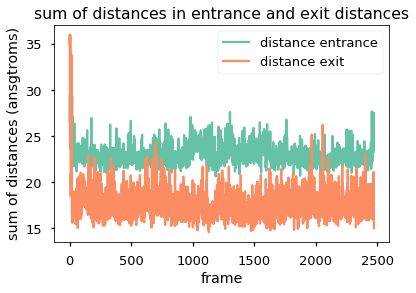

In [38]:
fig, ax = plt.subplots(1)
ax.plot(distance_entrance, label = 'distance entrance')
ax.plot(distance_exit, label = 'distance exit')
ax.legend()
ax.set_ylabel('sum of distances (ansgtroms)')
ax.set_xlabel('frame')
ax.set_title('sum of distances in entrance and exit distances')
plt.show()

In [37]:
print("entrance var is %8.3f" % distance_entrance.var())
print("exit var is %8.3f" % distance_exit.var())

entrance var is    1.197
exit var is    3.054


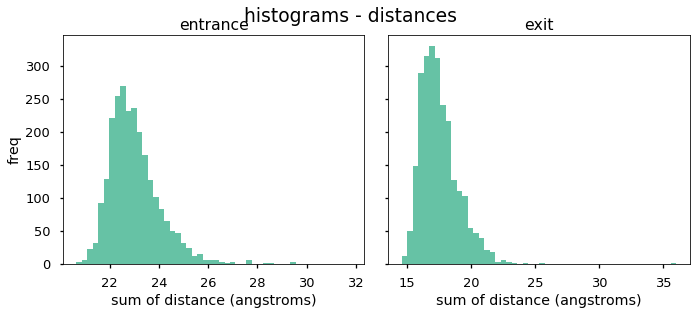

In [53]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(10,4.5)
ax[0].hist(distance_entrance, bins = 50)
ax[1].hist(distance_exit, bins = 50)
ax[0].set_xlabel('sum of distance (angstroms)')
ax[1].set_xlabel('sum of distance (angstroms)')
ax[0].set_ylabel('freq')
ax[0].set_title('entrance')
ax[1].set_title('exit')
fig.suptitle('histograms - distances')
plt.tight_layout()
plt.show()



## Tunnel CVs + difussion harmonic restraint


The objective of this block is setting the input for a metadynamics simulation in which we can probe the energy landscape and so we can understand the kinetics of pru p 3 ligand difussion.

We'll use the Molecular Dynamics simulations performed in pru p 3 + ligand to estimate the ranges of each of the paramters.


### Setting main and auxiliar difussion axis

To set the main difussion axis, we'll use the orthogonal decomposition of the MDpocket output, and we'll set an ensamble of atoms to fix its relative position


In [2]:

from mpl_toolkits.mplot3d import Axes3D

First we'll obtain what I call "difussion axis" ($z$): the main direction of space across the tunnel, and the auxiliary axis ($x,y$), which can represent a plane that is orthogonal to $z$. In order to do that, I need to diagonalize the covariance matrix $C$ of coordinates of the volume points corresponding to the pocket $P$.

$$ C = \frac{1}{m} PP^{T} $$

To obtain: 
\begin{align} 
    \lambda_{z} z & = C z \\
    \lambda_{x} x & = C x \\
    \lambda_{y} y & = C y 
\end{align}

We'll apply this concept to a MDPocket output obtained from conventional MD-simululations


In [3]:
# Read pocket dx file (just for representation)
tunnel_density = pyprob.volumetric(filename='C:/Users/Bruno/Dropbox/LTP/data/pockets/prup3_lig_A_freq.dx')
tunnel_density.read()
# Read MD-atom coordinates
prup3_complex = pdy.parsePDB(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/prup3_lig_A_0000.pdb'
)
# 
protein = prup3_complex.select('protein')
ligand = prup3_complex.select(
    'not protein and name ' + ' '.join(['C%d' %i for i in range(1,19)])
)

@ [volumetric] reading C:/Users/Bruno/Dropbox/LTP/data/pockets/prup3_lig_A_freq.dx - 12:02:27
@ [volumetric] volumetric tensor was created. Size x 65 y 70 z 65 - 12:02:27
@ [volumetric] origin coordinates were set to -32.520 -36.550 -31.140 - 12:02:27
@ [volumetric] dx reading is finished - 12:02:27


In [8]:
# Reading pocket to obtain principal components of the pocket
tn = pyprob.pocketProtCV(
    'C:/Users/Bruno/Dropbox/LTP/data/pockets/prup3_lig_A_freq.dx', 
    treshold = 0.2
)
coords = tn.get_pocket_coords()
variance, dif_axis   = tn.get_poteck_axis()
mc    = tn.get_pocket_center()


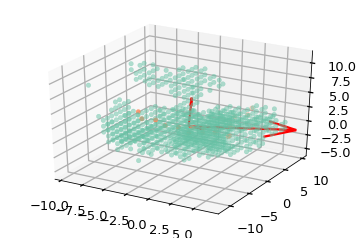

In [9]:
lig_coords = ligand.getCoords()
prot_coords = protein.getCoords()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0], coords[:,1], coords[:,2], alpha = 0.5)
ax.scatter(lig_coords[:,0], lig_coords[:,1], lig_coords[:,2])
ax.quiver(*mc, dif_axis[0, 0], dif_axis[1,0], dif_axis[2,0], length=variance[0]*0.5, color = 'r')
ax.quiver(*mc, dif_axis[0, 1], dif_axis[1,1], dif_axis[2,1], length=variance[1]*0.5, color = 'r')
ax.quiver(*mc, dif_axis[0, 2], dif_axis[1,2], dif_axis[2,2], length=variance[2]*0.5, color = 'r')
plt.show()

It coincides quite much. Now we have to find a set of atoms whose relative positions do not change during simulation. For that, we'll read the DM output and we'll set a list of Calphas sorted by their variance

In [12]:
#prup3_psf = pdy.parsePSF('F:DM/run1/prup3_lig_A/prup3_lig_A_charmm.psf')
prup3_dcd = pdy.parseDCD('F:DM/run1/prup3_lig_A/prup3_lig_A_nwater_pbcsolved.dcd')
ref       = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/prup3_lig_A_0000.pdb')
prup3_dcd.setAtoms(ref.calpha)
prup3_dcd.setCoords(ref)

In [13]:
prup3_dcd.superpose()
rmsf = prup3_dcd.getRMSFs()
hv = ref.getHierView()
resname = ["%3s" % (j) for i,j in enumerate(hv.iterResidues()) if i % 5 == 0]
pos = [i  for i,j in enumerate(hv.iterResidues()) if i % 5 == 0]

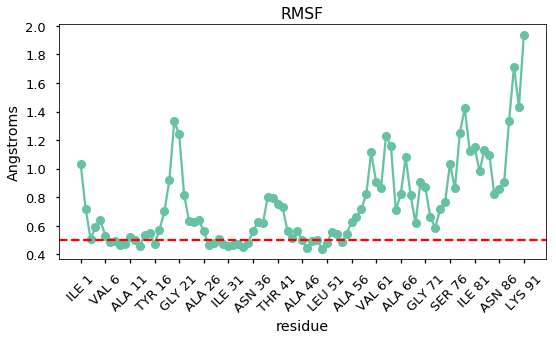

In [15]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,5)
ax.plot(rmsf, marker = 'o')
ax.set_xticks(pos)
ax.set_xticklabels(resname, rotation=45)
ax.set_title('RMSF')
ax.set_ylabel('Angstroms')
ax.set_xlabel('residue')
ax.axhline(0.5, linestyle='--', color = 'red')
plt.tight_layout()
plt.show()

Residues in the ranges 3-16, 26-31, 43-53 show low RMSF, so they should be a good anchorage for difussion axis. Now we'll create a file called *reference.pdb* in which we'll have defined the next groups by their occupancies:

- **anchor** : C-alphas of the most stable regions of the protein.
    - region 3-16
    - region 26-31
    - region 43-53
- **ligand** : C1-18 of the ligand. The aromatic head will not be included due to the possible  effects of its intrinsic torsions.

Moreover, mass-center coordinates of the selected ligand atoms and the main difussion axis values will be obtained


In [20]:
reference = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/ligA_bb_w.pdb')

In [21]:
anchor = reference.select('(resnum 3 to 16 or resnum 26 to 31 or resnum 43 to 53) and ca')
ligand = reference.select('not protein and name ' + ' '.join(['C%d' %i for i in range(1,19)]))

# All atoms will get occupancy 0.0
# Anchor atoms will get occupancy 1.0
# Ligand atoms will get occupancy 2.0
reference.setOccupancies(0.0)
anchor.setOccupancies(1.0)
ligand.setOccupancies(2.0)

pdy.writePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/reference.pdb', reference)

'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/reference.pdb'

The next step is setting the origin of the CV coordinates. Since we want to have an intuitive frame of reference, we'll set the reference position as the mass center value of the ligand in the docked complex. 

In [22]:
cntr = pdy.calcCenter(ligand)
main_axis = dif_axis[:, np.abs(variance).argmax()]

print("AXIS IS   : %5.3f %5.3f %5.3f" % (main_axis[0], main_axis[1], main_axis[2]))
print("CENTER IS : %5.3f %5.3f %5.3f" % (cntr[0], cntr[1], cntr[2]))

AXIS IS   : 0.332 0.898 -0.288
CENTER IS : -1.768 0.768 0.765


So now we can already set the CVs coordinates. Now, the next question is... how much do we expect the variables to change during simulation? For that, I have performed a preliminar META-MD in which values were excesive. Even though it created a rough landscape, it was interesting since it allows us to understand the ranges of each of the variables we have defined.

In [13]:
metamd_dcd = pdy.DCDFile('F:DM/run_2/metadm/ligA/metamd_lig_bb2_nw.dcd')
metamd_psf = pdy.parsePSF('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/ligA_bb.psf')
metamd_dcd.link(metamd_psf)
metamd_dcd.setAtoms(metamd_psf.select('protein'))

### Setting Tunnel CV calculation

In [14]:
for i, frame in enumerate(metamd_dcd):
    if i % 50 == 0 :
        pdy.writePDB(
            'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/ligA_bb_%04d' % i,
            frame
        )

### Reading Tunnel CV calculation and mapping CVs

In [15]:
simulation_ref = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/selected_groups.pdb')
simulation_ref = simulation_ref.select('not water and not ion')
#tunnel_CVs = pyprob.volumetric('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/mdpout_freq_grid.dx')
#tunnel_CVs.read()

In [16]:

ligand_group = simulation_ref.getOccupancies() == 1.0
mouth_group  = simulation_ref.getOccupancies() == 2.0
bottom_group = simulation_ref.getOccupancies() == 3.0

In [17]:
metamd_dcd = pdy.DCDFile('F:DM/run_2/metadm/ligA/metamd_lig_bb2_nw.dcd')
metamd_psf = pdy.parsePSF('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/ligA_bb.psf')
metamd_dcd.link(metamd_psf)


In [18]:
main_axis_distance = np.zeros(1000, dtype='float64')
tunnel_axis_distance = np.zeros(1000, dtype='float64')
tunnel_div_distance  = np.zeros(1000, dtype='float64')
aux_axis_distance  = np.zeros(1000, dtype='float64')
tn = pyprob.pocketProtCV(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/mdpout_freq_grid.dx', 0.2
)

#tn.set_mass_center(simulation_ref.getCoords()[ligand_group,:].mean(axis=0))

In [19]:
for i, frame in enumerate(metamd_dcd):
    if i == 0 :
        tn.set_mass_center(
            frame.getCoords()[ligand_group, :].mean(axis=0)
        )
    lig_center    = frame.getCoords()[ligand_group,:].mean(axis = 0)
    mouth_center  = frame.getCoords()[mouth_group,:].mean(axis = 0)
    bottom_center = frame.getCoords()[bottom_group,:].mean(axis = 0)
    
    dif_axis = (bottom_center - mouth_center) / np.linalg.norm(bottom_center- mouth_center)
    mean_point    = (mouth_center + bottom_center)/2.0
    distance_vector = lig_center - mean_point
    #tn.set_mass_center(lig)
    main_axis_distance[i] = dif_axis.dot(distance_vector)
    dx, dy = tn.calculateDifussionDistance(
        coords=frame.getCoords()[ligand_group,:]
    )
    
    tunnel_axis_distance[i] = dx
    tunnel_div_distance[i] = dy

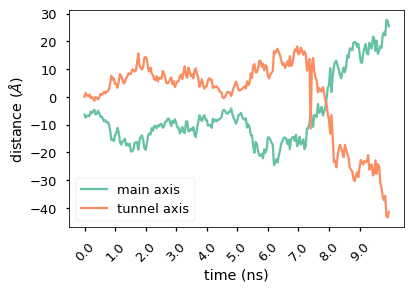

In [26]:
fig, ax = plt.subplots(1)

ax.plot(main_axis_distance[:250], label = 'main axis')
ax.plot(tunnel_axis_distance[:250], label = 'tunnel axis')
ax.legend()
ax.set_ylabel('distance ($\AA$)')
ax.set_xlabel('time (ns)')
ax.set_xticks(np.arange(0, 250, 25))
ax.set_xticklabels((np.arange(0, 250, 25) / 500)*20, rotation = 45)
plt.show()

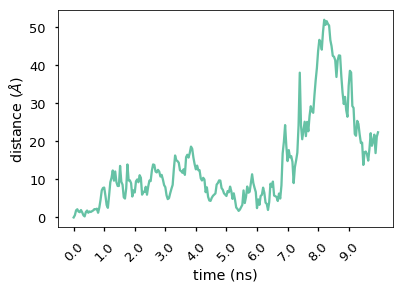

In [28]:
fig, ax = plt.subplots(1)
ax.plot(tunnel_div_distance[:250])
ax.set_ylabel('distance ($\AA$)')
ax.set_xlabel('time (ns)')
ax.set_xticks(np.arange(0, 250, 25))
ax.set_xticklabels((np.arange(0, 250, 25) / 500)*20, rotation = 45)

plt.show()

In [69]:

md_dcd = pdy.DCDFile('F:DM/run1/prup3_lig_A/prup3_lig_A_nwater_pbcsolved.dcd')
md_psf = pdy.parsePSF('F:DM/run1/prup3_lig_A/prup3_lig_A_charmm.psf')
md_dcd.link(md_psf)
tunnel_axis_distance = np.zeros(2500, dtype='float64')
tunnel_div_distance  = np.zeros(2500, dtype='float64')

tn = pyprob.pocketProtCV(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/tunnel/prup3_lig_A.dx', 0.2
)


md_dcd.setAtoms(
    md_psf.select(
        'not protein and name ' + ' '.join(['C%d' %i for i in range(1,19)])
    )
)
for i, frame in enumerate(md_dcd):
    if i == 0 : 
        tn.set_mass_center(frame.getCoords().mean(axis = 0))
    dx, dy = tn.calculateDifussionDistance(
        coords=frame.getCoords()
    )
    tunnel_axis_distance[i] = dx
    tunnel_div_distance[i]  = dy


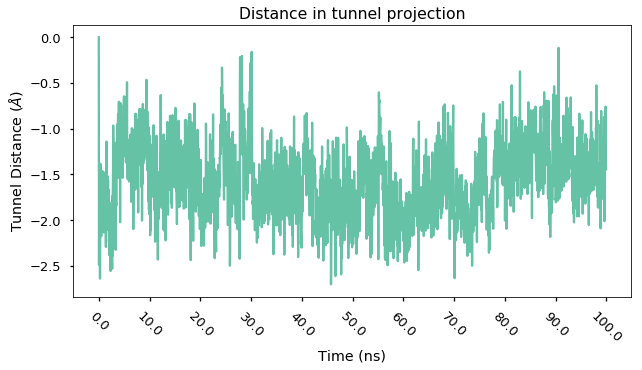

In [76]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,5)
ax.plot(tunnel_axis_distance)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Tunnel Distance ($\AA$)')
ax.set_xticks(np.arange(0, 2501, 250))
ax.set_xticklabels([20*i/500 for i in np.arange(0, 2501, 250)], rotation=-45)
ax.set_title('Distance in tunnel projection')
plt.show()

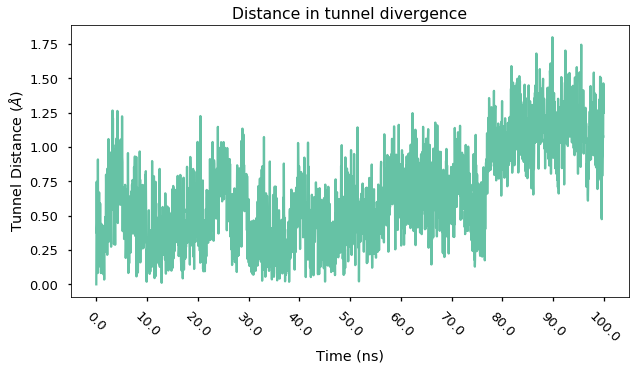

In [77]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,5)
ax.plot(tunnel_div_distance)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Tunnel Distance ($\AA$)')
ax.set_xticks(np.arange(0, 2501, 250))
ax.set_xticklabels([20*i/500 for i in np.arange(0, 2501, 250)], rotation = -45)
ax.set_title('Distance in tunnel divergence')
plt.show()

### Analysis of potential mean force landscape

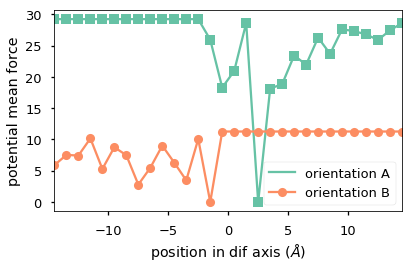

In [34]:
pmf_A = pd.read_table(
    'F:DM/run2/metadm/ligA/metamd_ligA_tunnel.pmf', comment='#', sep='\s+',
    names = ['distance', 'pmf']
)
pmf_A['orientation'] = 'A'
pmf_B = pd.read_table(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/metamd_ligB_tunnel.pmf', comment='#', sep='\s+',
    names = ['distance', 'pmf']
)
pmf_B['orientation'] = 'B'
pmf = pd.concat((pmf_A, pmf_B))
fig, ax = plt.subplots(1)
pmf_A.plot('distance', 'pmf', ax = ax, marker='s', label='orientation A')
pmf_B.plot('distance', 'pmf', ax = ax, marker='o', label='orientation B')
ax.set_ylabel('potential mean force')
ax.set_xlabel('position in dif axis ($\AA$)')
plt.tight_layout()
plt.savefig(r'C:\Users\Bruno\Dropbox\LTP\Meetings\Meeting5\Fig2.png')
plt.show()

### Analysis of pmf landscapes in well tempered dynamics


Since metadynamics looks to give place to an energy excess within the system, we will use well-tempered metadynamics in which the height of each of the gaussians decreases over time approaching to zero over time, avoiding thus energy excess and its associated inestability.

The thing with well-tempered metadynamics is that we have a new parameter, $\Delta T$, for which I have not found yet a good way to estimate it.

In the next code blocks, I'll see the PMF resulting from 5 different WT-Metadm-MD simulations at different $\Delta T$


In [2]:
path2data = 'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/well_tempered/'
wt_metadm_pmf_files = [
    'metamd_ligA_wt1000.pmf',
    'metamd_ligA_wt1200.pmf',
    'metamd_ligA_wt200.pmf',
    'metamd_ligA_wt600.pmf',
    'metamd_ligA_wt800.pmf'
]
pmf_list = [None for file in wt_metadm_pmf_files]
for i, file in enumerate(wt_metadm_pmf_files) :
    pmf_list[i] = pd.read_table(
         path2data + file, comment='#', sep='\s+',names = ['distance', 'pmf']
     )
    pmf_list[i]['temperature'] = int(file.replace('metamd_ligA_wt', '').replace('.pmf', ''))
     
pmf_data = pd.concat(pmf_list)
        



,distance,pmf,temperature
0,-14.5,6.47693,1000
1,-13.5,6.47693,1000
2,-12.5,6.47693,1000
3,-11.5,6.47693,1000
4,-10.5,6.47693,1000
5,-9.5,6.47693,1000
6,-8.5,6.47693,1000
7,-7.5,6.47693,1000
8,-6.5,6.47693,1000
9,-5.5,6.47693,1000


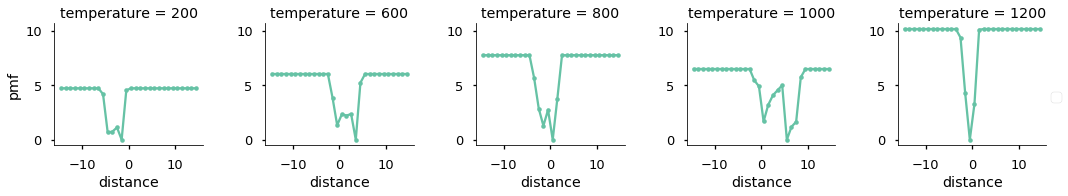

In [14]:
sns.set_context('talk')
g = sns.FacetGrid(data = pmf_data, col = 'temperature', size=3)
g.map(plt.plot, 'distance', 'pmf', marker = '.')
g.add_legend()
plt.show()

## Analysis of orientation

One of the key underlying variables in the pru p 3 binding process is the orientation of the ligand. Neglecting this variable might be the cause behind the fact that ligand can not bind back again.

The fist idea I came out with is to consider the angle between the difussion axis and the vector that joins the first and last atom of the lipid. Before running this try, we shall first see the variability of this variable in normal MD simulations, to check whether it keeps constant when ligands are bound in a certain orientation



In [188]:
psf_A = pdy.parsePSF('F:DM/run1/prup3_lig_A/prup3_lig_A_charmm.psf')
dcd_A = pdy.DCDFile('F:DM/run1/prup3_lig_A/prup3_lig_A_nwater_pbcsolved.dcd')

psf_B = pdy.parsePSF('F:DM/run1/prup3_lig_B/prup3_lig_B_charmm.psf')
dcd_B = pdy.DCDFile('F:DM/run1/prup3_lig_B/prup3_lig_B_nwater_pbcsolved.dcd')

dcd_A.link(psf_A)
dcd_B.link(psf_B)

In [189]:
angles_A = np.zeros(dcd_A.numFrames(), dtype='float64')
angles_B = np.zeros(dcd_B.numFrames(), dtype='float64')

In [190]:
import pyproblib
te = pyproblib.pocketProtCV('C:/Users/Bruno/Dropbox/LTP/Data/pockets/prup3_lig_A_freq.dx', treshold=0.2)
te_var, te_axis = te.get_poteck_axis()
dif_axis = te_axis[:, te_var.argmax()]
dif_axis /= np.linalg.norm(dif_axis)
cent = te.get_pocket_center()

In [191]:
v1

array([[-0.58949495, -0.76481749,  0.25990365]])

In [192]:
for i, fr in enumerate(dcd_A):
    header = fr.getAtoms().select('name C1 and not protein').getCoords()
    footer = fr.getAtoms().select('name C18 and not protein').getCoords()
    #vec    = header - footer
    #vec    /= np.linalg.norm(vec)
    #angles_A[i] = np.arccos(vec.dot(dif_axis))
    v1 = header - footer
    v1 /= np.linalg.norm(v1)
    angles_A[i] = np.arccos(v1.dot(dif_axis))


In [193]:
for i, fr in enumerate(dcd_B):
    header = fr.getAtoms().select('name C1 and not protein').getCoords()
    footer = fr.getAtoms().select('name C18 and not protein').getCoords()
    #vec    = header - footer
    #vec    /= np.linalg.norm(vec)
    v1 = header - footer
    
    v1 /= np.linalg.norm(v1)
    
    
    angles_B[i] = np.arccos(v1.dot(dif_axis))

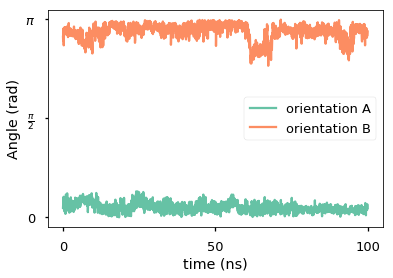

In [194]:
fig, ax = plt.subplots(1)
ax.plot(angles_A, label = 'orientation A')
ax.plot(angles_B, label = 'orientation B')
ax.set_ylabel('Angle (rad)')
ax.set_yticks([0.0, 0.5*np.pi, np.pi])
ax.set_yticklabels(['0', r'$\frac{\pi}{2}$', '$\pi$'])
ax.set_xticks([0, 1250, 2500])
ax.set_xticklabels(['0', '50', '100'])
ax.set_xlabel('time (ns)')
ax.legend()
plt.show()

This looks quite cool. Now, we'll take a look at what happens when ligans are unbound, in MD simulations

In [74]:
dcd_A_ub = pdy.DCDFile('F:DM/run2/metadm/ligA/metamd_ligA_tunnel_nw.dcd')
psf_A_ub = pdy.parsePSF('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/ligA_bb.psf')

dcd_B_ub = pdy.DCDFile('F:DM/run2/metadm/ligB/metamd_ligB_tunnel_nw.dcd')
psf_B_ub = pdy.parsePSF('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/input/ligB_bb.psf')

dcd_A_ub.link(psf_A_ub)
dcd_B_ub.link(psf_B_ub)
angle_A_ub = np.zeros(dcd_A_ub.numFrames(), dtype='float64')
angle_B_ub = np.zeros(dcd_B_ub.numFrames(), dtype='float64')
tn_A = pyproblib.pocketProtCV(
    'F:DM/run2/metadm/ligA/pocket/metamd_ligA_bb_tunel_freq.dx', 0.2
)
tn_B = pyproblib.pocketProtCV(
    'F:DM/run2/metadm/ligA/pocket/metamd_ligA_bb_tunel_freq.dx', 0.2
)
te_var_A, te_axis_A = tn_A.get_poteck_axis()
dif_axis_A = te_axis_A[:, te_var_A.argmax()]
dif_axis_A /= np.linalg.norm(dif_axis_A)

te_var_B, te_axis_B = tn_B.get_poteck_axis()
dif_axis_B = te_axis_B[:, te_var_B.argmax()]
dif_axis_B /= np.linalg.norm(dif_axis_B)

In [75]:
for i, fr in enumerate(dcd_A_ub):
    header = fr.getAtoms().select('name C1 and not protein').getCoords()
    footer = fr.getAtoms().select('name C18 and not protein').getCoords()
    vec    = header - footer
    vec    /= np.linalg.norm(vec)
    angle_A_ub[i] = np.arccos(vec.dot(dif_axis_A))
    
for i, fr in enumerate(dcd_B_ub):
    header = fr.getAtoms().select('name C1 and not protein').getCoords()
    footer = fr.getAtoms().select('name C18 and not protein').getCoords()
    vec    = header - footer
    vec    /= np.linalg.norm(vec)
    angle_B_ub[i] = np.arccos(vec.dot(dif_axis_B))

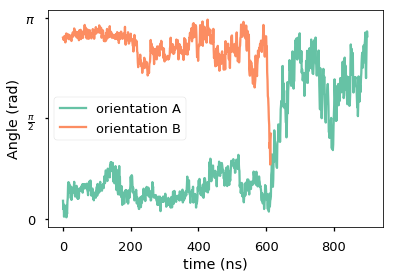

In [77]:
fig, ax = plt.subplots(1)
ax.plot(angle_A_ub, label = 'orientation A')
ax.plot(angle_B_ub, label = 'orientation B')
ax.set_ylabel('Angle (rad)')
ax.set_yticks([0.0, 0.5*np.pi, np.pi])
ax.set_yticklabels(['0', r'$\frac{\pi}{2}$', '$\pi$'])
ax.set_xlabel('time (ns)')
ax.legend()
plt.show()

## Analysis of plumed colvars

In [98]:
path2data = 'C:/scratch/'
colvars_data = path2data + 'plumed_colvars'
dcd_file = path2data + 'ligA_bb_md_nw.dcd'
psf_file = path2data + 'ligA_bb.psf'
# ----------------- reading data
dcd = pdy.DCDFile(dcd_file)
psf = pdy.parsePSF(psf_file)

In [99]:
center = np.array([-0.009,0.950,0.936], dtype='float64')
center_axis = np.array([0.323,1.848,0.648], dtype='float64') 
selected_atoms = [
    1277,1278,1327,1334,1335,1339,1340,1345,1346,1351,1352,1357,1358,1369,1370,1375
]


In [100]:
dcd.link(psf)
onaxis_array = np.zeros(dcd.numFrames(), dtype='float64')
fromaxis_array = np.zeros(dcd.numFrames(), dtype='float64')

onaxis = lambda x, y, z : 0.5 * ((y.dot(y.T)) - (x.dot(x.T))) / np.linalg.norm(z)
fromaxis = lambda x, y, z, w : 0.5 * (y.dot(y) + x.dot(x)) - (w**2) - 0.25 * z.dot(z)
for i, frame in enumerate(dcd):
    print("processing %d" % i)
    frame_atoms = frame.getAtoms()
    sel_coords =  frame_atoms.getCoords()[[selected_atoms]].mean(axis = 0)
    # ------------------ç
    
    O = onaxis(sel_coords - center, sel_coords - center_axis, center_axis - center)
    F = fromaxis(sel_coords - center, sel_coords - center_axis, center_axis - center, O)
        
    # ------------------
    onaxis_array[i] = O
    fromaxis_array[i] = F

processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 18
processing 19
processing 20
processing 21
processing 22
processing 23
processing 24


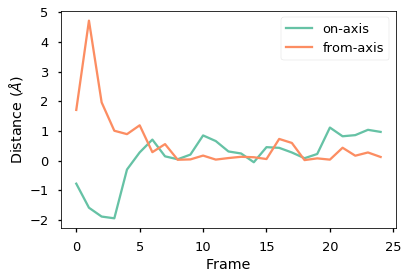

In [102]:
fig, ax = plt.subplots(1)
ax.plot(onaxis_array, label ='on-axis')
ax.plot(fromaxis_array, label = 'from-axis')
ax.legend()
ax.set_ylabel('Distance ($\AA$)')
ax.set_xlabel('Frame')
plt.show()

In [103]:
dat = pd.read_table(
    colvars_data, sep="\s+", comment='#', header=None, names=['time', 'on-axis','from-axis']
)

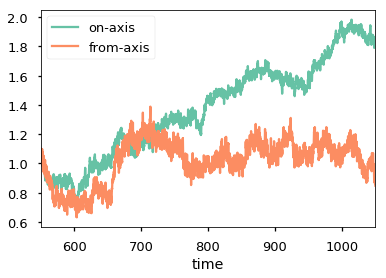

In [104]:
fig, ax = plt.subplots(1)
dat.plot(x='time', y='on-axis', ax=ax)
dat.plot(x='time', y='from-axis', ax=ax)
plt.show()

## Seting PLUMED coords

In [108]:
ligA_bb_w = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/ligA_bb_w.pdb')

In [129]:
ligA_bb_w.setOccupancies(0.0)
sel = ligA_bb_w.select('ca and within 5.0 of (hetero and not water and not ion)')
sel.setOccupancies(1.0)
ca = sel.getCoords()
pdy.calcCenter(ca)
#pdy.writePDB(atoms=ligA_bb_w, filename='foo.pdb')

array([-1.696  ,  1.66195,  0.3132 ])

In [141]:
lig = ligA_bb_w.select('name ' +' '.join(['C%d' % i for i in range(18)]) + ' and not protein')
pdy.calcCenter(lig)

array([-1.418     ,  0.84052941,  0.73152941])

In [155]:
atom = ligA_bb_w.select('name CA and resnum 35')
atom.getSerials()

array([467])

In [154]:
entrance_list = [35, 36, 38, 39, 44, 76, 77, 78, 75]
exit_list = [55, 61, 66, 82, 83]

In [172]:
entrance = ligA_bb_w.select('name CA and resnum ' + ' '.join(['%d' % i for i in entrance_list]))
exit = ligA_bb_w.select('name CA and resnum ' + ' '.join(['%d' % i for i in exit_list]))
print(",".join([str(i.getIndex() + 1) for i in entrance]))
print(",".join([str(i.getIndex() + 1) for i in exit]))

467,481,514,524,602,1024,1040,1051,1072
774,843,915,1146,1157


In [168]:
for atom in entrance:
    print(atom)

Atom CA (index 466)
Atom CA (index 480)
Atom CA (index 513)
Atom CA (index 523)
Atom CA (index 601)
Atom CA (index 1023)
Atom CA (index 1039)
Atom CA (index 1050)
Atom CA (index 1071)


## Analyzing output from well-tempered metadynamics

Metadynamics simulations in NAMD-colvars provides the next output files:
- **colvars traj file** the values of the the colvars each update step
- **hills traj file** the values of the centers, width and height of the hills added
- **pmf** the value of the potential mean force landscape - which in this case, would be the sum of all the gaussians, computed by NAMD-colvars.

We'll represent the three files.

In [3]:
def read_metadynamics_output(basename) : 
    # Reading hills
    print(f'[METADYN] reading {basename}.hills')
    hills_instance = pd.read_table(basename + '.hills',sep="\s+", header = None, index_col = False)
    hills_instance.columns = ['time', 'z', 'width', 'height']
    hills_instance['time'] -= 55000
    # Reading colvars
    print(f'[METADYN] reading {basename}.colvars')
    colvars_instance = pd.read_table(basename + '.colvars',sep="\s+", header = None, index_col = False, comment='#')
    colvars_instance.columns = ['time', 'z', 'xy']
    colvars_instance['time'] -= 55000
    # Reading Potential Mean Force
    print(f'[METADYN] reading {basename}.pmf')
    pmf_instance = pd.read_table(basename + '.pmf', sep = '\s+', header=None, index_col=False, comment='#')
    pmf_instance.columns = ['z', 'PMF']
    # returning all three
    return  hills_instance, colvars_instance, pmf_instance

In [3]:
hills_1, colvars_1, pmf_1 = read_metadynamics_output('F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_01')

[METADYN] reading F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_01.hills
[METADYN] reading F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_01.colvars
[METADYN] reading F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_01.pmf


In [64]:
hills_2, colvars_2, pmf_2 = read_metadynamics_output('F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_02')

[METADYN] reading F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_02.hills
[METADYN] reading F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_02.colvars
[METADYN] reading F:DM/run2/metadm/ligA/wtmetamd/run_04/meta_04_02.pmf


In [65]:
hills_A = pd.concat((hills_1, hills_2))
colvars_A = pd.concat((colvars_1, colvars_2))

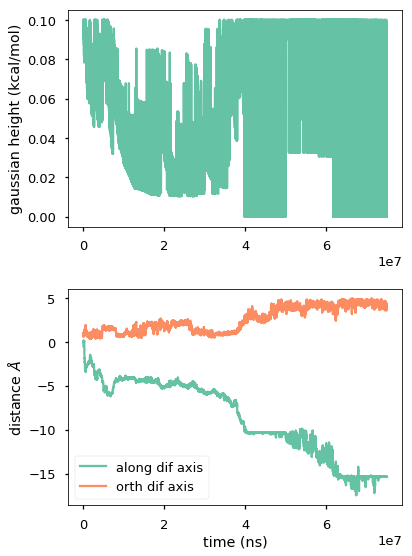

In [66]:
fig, ax = plt.subplots(2)
fig.set_size_inches(6,8)
#y = hills_A['height'].rolling(window=50).mean()
#x = y.index * 500 / (1e6)
x = hills_A['time'] 
y = hills_A['height']
z = hills_A['z'].rolling(window=50).mean()
xy = colvars_A['xy'].rolling(window=50).mean()
ax[0].plot(x,y)
ax[1].plot(x, z, label = 'along dif axis')
ax[1].plot(x, xy, label='orth dif axis')
ax[1].set_xlabel('time (ns)')
ax[0].set_ylabel('gaussian height (kcal/mol)')
ax[1].set_ylabel('distance $\AA$')
ax[1].legend()
plt.tight_layout()
plt.show()

In [67]:
def plot_deposition(hhh, ax):
    hist = ax.hexbin(hhh['z'], hhh['height'], bins='log', cmap='nipy_spectral')
    zmin = hhh['z'].min()
    zmax = hhh['z'].max()
    hmin = hhh['height'].min()
    hmax = hhh['height'].max()
    #bar  = ax.colorbar(hist)
    #bar.set_label('$\log_{10}$ counts')
    ax.axis([zmin, zmax, hmin, hmax])
    ax.set_xlabel('distance $\AA$')
    ax.set_ylabel('gaussian height (kcal/mol)')
    #ax.set_yscale('log')
    #plt.show()

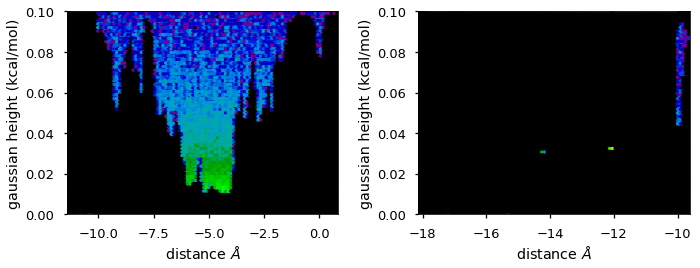

In [68]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 4)
plot_deposition(hills_1, ax[0])
plot_deposition(hills_2, ax[1])
plt.tight_layout()
plt.show()

In [69]:
hills_A.query('height > 0.3')

,time,z,width,height


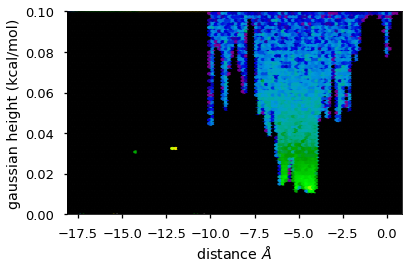

In [70]:

fig, ax = plt.subplots(1)
fig.set_size_inches(6, 4)
plot_deposition(hills_A, ax)
plt.tight_layout()
plt.show()

**Important**

The gaussians expressions is the following. It took me a while to discover it, so that I had to read the colvars C++ code...

$$G(z)=h \exp\left(\frac{\|z-z_{0}\|^{2}}{2 \delta^{2}}\right) $$

where $ \delta = \frac{\sigma}{2} $


In [7]:
def gaussian_sum(height, width, val, spacing = 0.01):
    z_axis = np.arange(val.min() - spacing, val.max() + spacing, 0.1)
    e_axis = np.zeros(z_axis.size)
    for i in range(val.size):
        d = z_axis - val[i]
        e_axis += height[i] * np.exp(-0.5 * (d**2) / ((0.5*width[i])**2))
        #e_axis += height[i] * np.exp(-0.5 * (d**2) / (0.008**2))
    return z_axis, e_axis

In [3]:
foo = pd.read_table('C:/scratch/ligA_bb_md.colvars.meta_06.hills.traj',sep="\s+", header = None, index_col = False)
foo.columns = ['time', 'z', 'width', 'height']
foo['time'] -= 55000

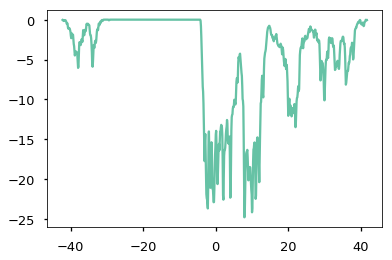

In [6]:
Z,E= gaussian_sum(foo['height'].values, foo['width'].values, foo['z'].values, spacing=0.1)
bias_factor =  (4500.0 / (298.0 + 4500.0))
E_c = E-E.min()
E_c *= bias_factor
plt.plot(Z,-E_c)
plt.show()

In [72]:
Z2,E2 = gaussian_sum(hills_2['height'].values,hills_2['width'].values,hills_2['z'].values, spacing=0.1)
Z1,E1 = gaussian_sum(hills_1['height'].values,hills_1['width'].values,hills_1['z'].values, spacing=0.1)
ZA,EA = gaussian_sum(hills_A['height'].values, hills_A['width'].values,hills_A['z'].values, spacing=0.1)

In [73]:
basename = 'C:/scratch/ligA_bb_md_cont1.pmf'
pmf_instance = pd.read_table(basename, sep = '\s+', header=None, index_col=False, comment='#')
pmf_instance.columns = ['z', 'PMF']

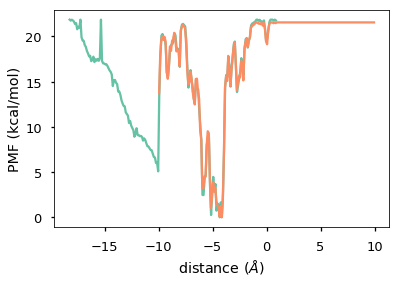

In [74]:
fig, ax = plt.subplots(1)
#bias_factor =  (4500.0 / (298.0 + 4500.0))*1.15
E_c1 = -E1 * bias_factor 
E_c1 -= E_c1.min()
E_c2 = -E2 * bias_factor 
E_c2 -= E_c2.min()
#E_cA = -EA * bias_factor 
E_cA -= E_cA.min()
ax.plot(ZA,E_cA)
plt.plot(pmf_2['z'], pmf_2['PMF'])
ax.set_ylabel('PMF (kcal/mol)')
ax.set_xlabel('distance ($\AA$)')
plt.show()

In [351]:
bias_factor * 0.82


0.7690704460191746

In [304]:
dcd = pdy.DCDFile('F:/DM/run2/metadm/ligA/wtmetamd/run_04/run_04_processed.dcd')
psf = pdy.parsePSF('F:/DM/run2/metadm/ligA/ligA_bb.psf')
dcd.link(psf)

In [305]:
dif_vector = np.array([0.332, 0.898, -0.288])
B = np.zeros((3,3), dtype='float64')
B[:,0] = dif_vector
B[:,1] = -0.898/0.332, 1, 0
B[:,1] /= np.linalg.norm(B[:,1])
B[:,2] = np.cross(B[:,0], B[:,1])
B_inv = np.linalg.inv(B)

In [306]:
dist = np.zeros(dcd.numFrames(), dtype='float64')
orth = np.zeros(dcd.numFrames(), dtype='float64')
C = np.array([-0.009, 0.950, 0.936])
for i, fr in enumerate(dcd) : 
    atoms = fr.getAtoms()
    lig = atoms.select('segment HETA and name ' + ' '.join(['C%d' % i for i in range(19)]))
    cc2 = lig.getCoords().mean(axis = 0) - C
    dist[i] = dif_vector.dot(cc2)
    orth[i] = np.linalg.norm(cc2 - (cc2.dot(dif_vector))*dif_vector)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


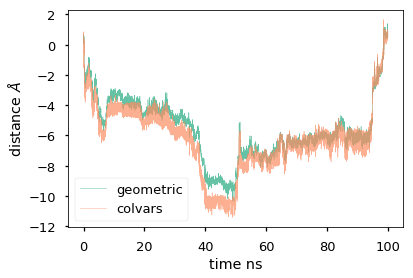

In [310]:
fig, ax = plt.subplots(1)
#ax.plot(np.arange(0, 5e1, 2e-2), dist1, label='centered', linewidth=0.5)
ax.plot(np.arange(0, 10e1, 2e-2), dist, label='geometric', linewidth=0.5)
ax.plot(np.arange(0, 10e1 + 10e-4, 5e-4), hills_A['z'], linewidth=0.5, label='colvars', alpha = 0.7)
ax.set_xlabel('time ns')
ax.set_ylabel('distance $\AA$')
ax.legend(loc = 'lower left')
plt.show()

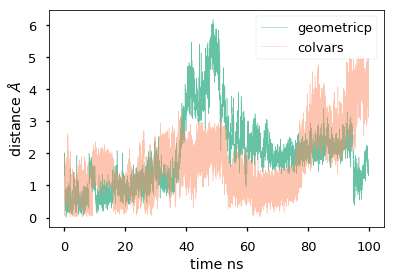

In [314]:
fig, ax = plt.subplots(1)
ax.plot(np.arange(0, 1e2, 2e-2), orth, label='geometricp', linewidth=0.5)
ax.plot(np.arange(0, 1e2 + 1e-3, 1e-3), colvars['xy'], linewidth=0.5, label='colvars', alpha = 0.5)
ax.set_xlabel('time ns')
ax.set_ylabel('distance $\AA$')
ax.legend(loc = 'upper right')
plt.show()

In [319]:
Z_sampled = Z[::5]
E_sampled = E[::5]

In [320]:
from scipy.signal import argrelextrema
XX = argrelextrema(-E_sampled, np.greater)[0]

In [321]:
integrals = np.zeros(XX.size + 1, dtype='float64')
integrals[0] = np.trapz(E_sampled[:XX[0]], dx = 0.1)
for i in range(XX.size-1) :
    integrals[i+1] = np.trapz(E_sampled[XX[i]:XX[i+1]], dx = 0.1)
integrals[-1] = np.trapz(E_sampled[XX[-i]:], dx = 0.1)

In [322]:
integrals

array([ 2.0308476 ,  3.0233822 , 15.19337526,  0.92557952,  1.21050066,
        4.09054015])

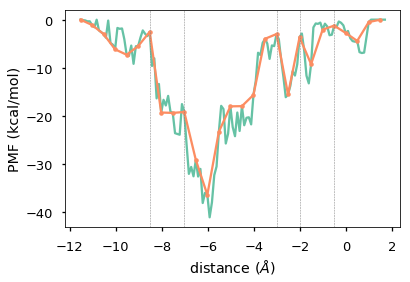

In [324]:
fig, ax = plt.subplots(1)
ax.plot(Z,-E)
#ax.plot(Z, der)
plt.plot(Z_sampled, -E_sampled, marker = '.')
for i in range(XX.size):
    plt.axvline(Z_sampled[XX[i]], linewidth=0.5, linestyle='--', color='gray')
ax.set_ylabel('PMF (kcal/mol)')
ax.set_xlabel('distance ($\AA$)')
plt.show()

## Preparing ligB simulation

In [2]:
reference = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/ligB_bb_w.pdb')
anchor = reference.select('(resnum 3 to 16 or resnum 26 to 31 or resnum 43 to 53) and ca')
ligand = reference.select('not protein and name ' + ' '.join(['C%d' %i for i in range(1,19)]))

# All atoms will get occupancy 0.0
# Anchor atoms will get occupancy 1.0
# Ligand atoms will get occupancy 2.0
reference.setOccupancies(0.0)
anchor.setOccupancies(1.0)
ligand.setOccupancies(2.0)

pdy.writePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/input/reference.pdb', reference)

'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/input/reference.pdb'

In [4]:
cntr = pdy.calcCenter(ligand)
print(cntr)

[-1.12633333 -0.32633333  0.2485    ]


## Comparing energy landscape between Potential Mean Force file and sum of gaussians from hills file

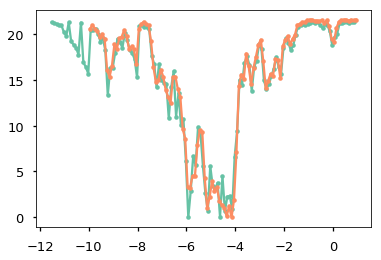

In [190]:
bias_factor =  4500.0 / (298.0 + 4500.0)
#bias_factor=0.95
E_corrected = -E * bias_factor
E_corrected = E_corrected - E_corrected.min()



plt.plot(Z, E_corrected, marker = '.')
plt.plot(pmf_file['z'][:110], pmf_file['PMF'][:110], marker = '.')
plt.show()

## Simulation of opening conformational change in pru p 3

May pru p 3 behave like a saposin? Maybe. We'll explore the conformational lanscape of pru p 3 by imposing a modification on the underlying potential that involves:
- **A well-tempered metadynamics potential** applied to gyration radius of the protein, to observe changes in size of the protein.
- **A set of harmonic bias** applied to RMSD of the secondary structures of the protein, in order to avoid changes due to the loss of secondary structure, avoiding possible artifacts.

First we need an evaluation of the changes that those variables take during simulation.

In [142]:
ligA_psf = pdy.parsePSF('F:DM/run1/prup3_lig_A/prup3_lig_A_charmm.psf')
ligA_dcd = pdy.DCDFile('F:DM/run1/prup3_lig_A/prup3_lig_A_nwater_pbcsolved.dcd')
#selection = '(resnum 3 to 16 or resnum 26 to 31 or resnum 43 to 53) and ca'
selection = '((resnum 3 to 20) or (resnum 25 to 38) or (resnum 43 to 53) or (resnum 64 to 73)) and ca'
#sel_h1 = '(resnum 3 to 16) and ca'
#sel_h2 = '(resnum 26 to 31) and ca'
#sel_h3 = '(resnum 43 to 53) and ca'

sel_h1 = '(resnum 3 to 20) and ca'
sel_h2 = '(resnum 25 to 38) and ca'
sel_h3 = '(resnum 43 to 53) and ca'
sel_h4 = '(resnum 64 to 73) and ca'



ligA_dcd.link(ligA_psf)

In [143]:
initial_structure = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/prup3_lig_A_0000.pdb')
initial_h1 = initial_structure.select(sel_h1).getCoords()
initial_h2 = initial_structure.select(sel_h2).getCoords()
initial_h3 = initial_structure.select(sel_h3).getCoords()
initial_h4 = initial_structure.select(sel_h4).getCoords()

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


In [144]:
rg = np.zeros(2500, dtype='float64')
rmsd_h1 = np.zeros(2500, dtype='float64')
rmsd_h2 = np.zeros(2500, dtype='float64')
rmsd_h3 = np.zeros(2500, dtype='float64')
rmsd_h4 = np.zeros(2500, dtype='float64')
for i, frm in enumerate(ligA_dcd):
    
    at = frm.getAtoms().select(selection)
    rg[i] = pdy.calcGyradius(at)
    
    h1_select = frm.getAtoms().select(sel_h1).getCoords()
    h2_select = frm.getAtoms().select(sel_h2).getCoords()
    h3_select = frm.getAtoms().select(sel_h3).getCoords()
    h4_select = frm.getAtoms().select(sel_h4).getCoords()
    
    rot_h1, _ = pdy.superpose(h1_select, initial_h1)
    rot_h2, _ = pdy.superpose(h2_select, initial_h2)
    rot_h3, _ = pdy.superpose(h3_select, initial_h3)
    rot_h4, _ = pdy.superpose(h4_select, initial_h4)
    
    rmsd_h1[i] = pdy.calcRMSD(initial_h1, rot_h1)
    rmsd_h2[i] = pdy.calcRMSD(initial_h2, rot_h2)
    rmsd_h3[i] = pdy.calcRMSD(initial_h3, rot_h3)
    rmsd_h4[i] = pdy.calcRMSD(initial_h4, rot_h4)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


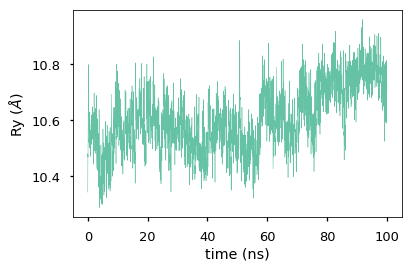

In [145]:
fig, ax = plt.subplots(1)
ax.plot(np.arange(0, 1e2, 0.04), rg, linewidth=0.5)
ax.set_xlabel('time (ns)')
ax.set_ylabel('Ry ($\AA$)')
fig.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/ts_gyr_radius.png', dpi=300)
plt.show()

In [13]:
def norm_distribution(mu, var, range_x):
    x = np.arange(range_x[0], range_x[1], range_x[2], dtype='float64')
    y = (1/(np.sqrt(2*np.pi*var)))*np.exp(-((x-mu)**2)/(2*var))
    return x,y

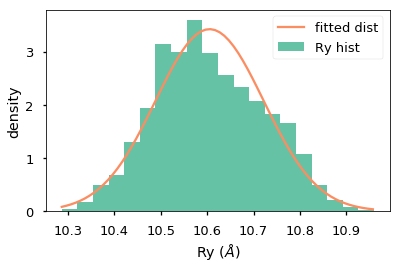

In [147]:
fig, ax = plt.subplots(1)
ax.hist(rg, density = True, bins=20, label='Ry hist')
x, y = norm_distribution(np.mean(rg), np.var(rg), [rg.min(), rg.max(), 0.01])
ax.plot(x, y, label='fitted dist')
ax.set_xlabel('Ry ($\AA$)')
ax.set_ylabel('density')
ax.legend()
fig.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/hist_gyr_radius.png', dpi=300)
plt.show()

In [148]:
var_rg = np.var(rg)
mean_rg = np.mean(rg)

print(f"var is : {var_rg}")
print(f"mean is : {mean_rg}")

var is : 0.013570363510589229
mean is : 10.605340732363109


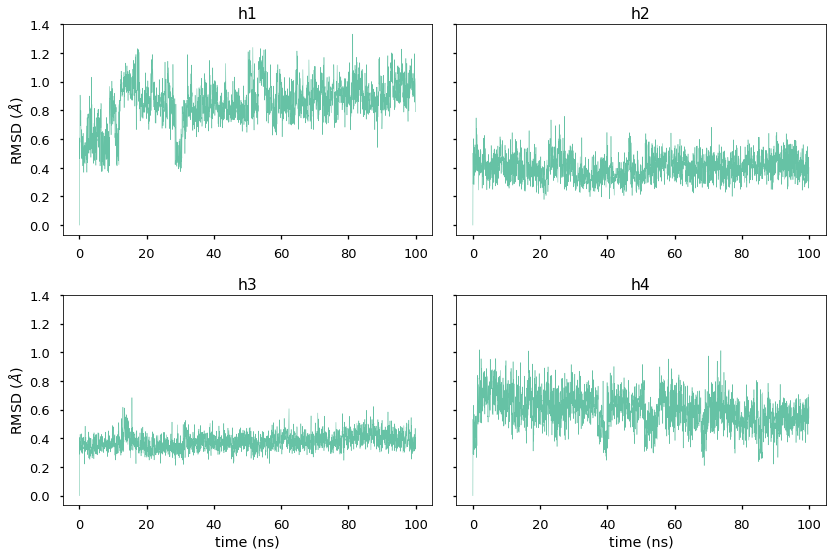

In [74]:
fig, ax = plt.subplots(2,2, sharey=True)
fig.set_size_inches(12,8)
ax[0,0].plot(np.arange(0, 1e2, 0.04), rmsd_h1, linewidth=0.5)
ax[0,0].set_title('h1')
ax[0,1].plot(np.arange(0, 1e2, 0.04), rmsd_h2, linewidth=0.5)
ax[0,1].set_title('h2')
ax[1,0].plot(np.arange(0, 1e2, 0.04), rmsd_h3, linewidth=0.5)
ax[1,0].set_title('h3')
ax[1,1].plot(np.arange(0, 1e2, 0.04), rmsd_h4, linewidth=0.5)
ax[1,1].set_title('h4')
ax[1,0].set_ylabel('RMSD ($\AA$)')
ax[0,0].set_ylabel('RMSD ($\AA$)')
ax[1,0].set_xlabel('time (ns)')
ax[1,1].set_xlabel('time (ns)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/ts_rmsd_helix.png', dpi=300)
plt.show()

In [14]:
def plot_hooke(mu, k, range_x):
    x = np.arange(range_x[0], range_x[1], range_x[2], dtype='float64')
    y = 0.5*k*((x - mu)**2)
    return x,y

In [15]:
def plot_everything(h, ax):
    ax.hist(h, bins=20, density = True)
    x,y = norm_distribution(h.mean(), h.var(), [h.min(), h.max(), 0.01])
    l,m = plot_hooke(h.mean(), 0.25/h.var(), [h.min(), h.max(), 0.01])
    ax.plot(x,y, label='fitted')
    ax.plot(l,m, label='hooke')

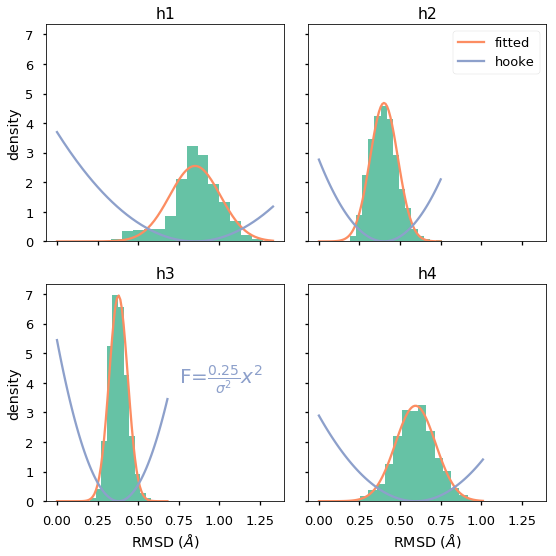

In [88]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(8,8)

plot_everything(ax=ax[0, 0], h=rmsd_h1)
plot_everything(ax=ax[0, 1], h=rmsd_h2)
plot_everything(ax=ax[1, 0], h=rmsd_h3)
plot_everything(ax=ax[1, 1], h=rmsd_h4)

ax[0, 0].set_title('h1')
ax[0, 1].set_title('h2')
ax[1, 0].set_title('h3')
ax[1, 1].set_title('h4')

ax[1,1].set_xlabel('RMSD ($\AA$)')
ax[1,0].set_xlabel('RMSD ($\AA$)')
ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')
ax[0,1].legend()
ax[1,0].text(0.75,4.0, r'F=$\frac{0.25}{\sigma^{2}} x^{2}$', size=20, 
             color = sns.color_palette('Set2')[2])
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/hist_rmsd_helix.png', dpi=300)
plt.show()

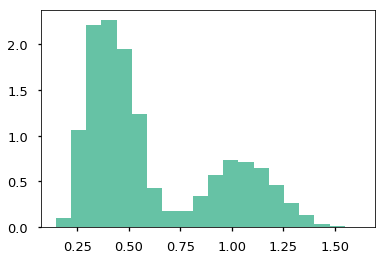

In [112]:
fig, ax = plt.subplots(1)
ax.hist(np.concatenate((rmsd_h1, rmsd_h2, rmsd_h3)), density = True, bins = 20)
plt.show()

In [89]:
means = np.array([rmsd_h1.mean(),rmsd_h2.mean(), rmsd_h3.mean(), rmsd_h4.mean()])
variances = np.array([rmsd_h1.var(),rmsd_h2.var(), rmsd_h3.var(), rmsd_h4.var()])
ks = 0.25 / variances
hname = ['H1', 'H2', 'H3', 'H4']
lower_range = [3, 25, 42, 64]
upper_range = [20, 38, 58, 73]
helix_table = pd.DataFrame.from_items(
    [
        ('name', hname), ('lr', lower_range), ('ur', upper_range),
        ('k', ks), ('mu', means), ('vars', variances)
    ]
)

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  # Remove the CWD from sys.path while we load stuff.


In [90]:
helix_table

,name,lr,ur,k,mu,vars
0,H1,3,20,10.235562,0.850530,0.024425
1,H2,25,38,34.452642,0.401370,0.007256
2,H3,42,58,76.036955,0.379044,0.003288
3,H4,64,73,16.370738,0.595337,0.015271


In [91]:
helix_table.to_csv('C:/Users/Bruno/Dropbox/LTP/data/opening/rmsd_no_bias.csv')

In [95]:
pd.read_csv('C:/Users/Bruno/Dropbox/LTP/data/opening/rmsd_no_bias.csv',comment= '#', index_col=0)

,name,lr,ur,k,mu,vars
0,H1,3,20,10.235562,0.850530,0.024425
1,H2,25,38,34.452642,0.401370,0.007256
2,H3,42,58,76.036955,0.379044,0.003288
3,H4,64,73,16.370738,0.595337,0.015271


In [151]:
selection

'((resnum 3 to 20) or (resnum 25 to 38) or (resnum 43 to 53) or (resnum 64 to 73)) and ca'

In [153]:
h1 = initial_structure.select(sel_h1)
h2 = initial_structure.select(sel_h2)
h3 = initial_structure.select(sel_h3)
h4 = initial_structure.select(sel_h4)
initial_structure.setOccupancies(0.0)
initial_structure.setBetas(0.0)
h1.setOccupancies(1.0)
h2.setOccupancies(2.0)
h3.setOccupancies(3.0)
h4.setOccupancies(4.0)
ensemble_helix = initial_structure.select(selection)
ensemble_helix.setBetas(1.0)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


In [154]:
pdy.writePDB(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/reference_helix_rmsd.pdb', 
    initial_structure
)

'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/reference_helix_rmsd.pdb'

## Analyzing RMSD-restrained simulation

In [98]:
run_07_colvars = pd.read_table( 
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_07/run_07.colvars', 
    sep="\s+", comment='#', header = None
)
run_07_colvars.columns = ['step', 'r1','r2', 'r3', 'r4', 'e1', 'e2', 'e3', 'e4']
run_07_colvars['step'] -= 55000
run_07_colvars[:10]

,step,r1,r2,r3,r4,e1,e2,e3,e4
0,0,0.744587,0.233145,0.237550,0.399033,0.057467,0.479555,0.771505,0.330574
1,500,0.695775,0.330811,0.364595,0.291351,0.122619,0.082457,0.009023,0.779738
2,1000,0.677059,0.381499,0.357153,0.360471,0.154072,0.005896,0.019846,0.469606
3,1500,0.436681,0.365155,0.351267,0.392244,0.876908,0.020914,0.031388,0.353284
4,2000,0.541387,0.389056,0.356470,0.451925,0.489317,0.002063,0.021050,0.179465
5,2500,0.603877,0.312656,0.352439,0.340957,0.311489,0.131409,0.028880,0.549242
6,3000,0.583093,0.330459,0.351472,0.465230,0.366195,0.083300,0.030942,0.148663
7,3500,0.568157,0.381919,0.346641,0.516377,0.408239,0.005631,0.042310,0.057236
8,4000,0.442821,0.323716,0.312895,0.489061,0.851079,0.100237,0.171209,0.100736
9,4500,0.438073,0.360499,0.348201,0.283149,0.871020,0.026877,0.038446,0.821728


In [28]:
def plot_everything(h, ax):
    ax.hist(h, bins=20, density = True)
    x,y = norm_distribution(h.mean(), h.var(), [h.min(), h.max(), 0.01])
    ax.plot(x,y, label='fitted')

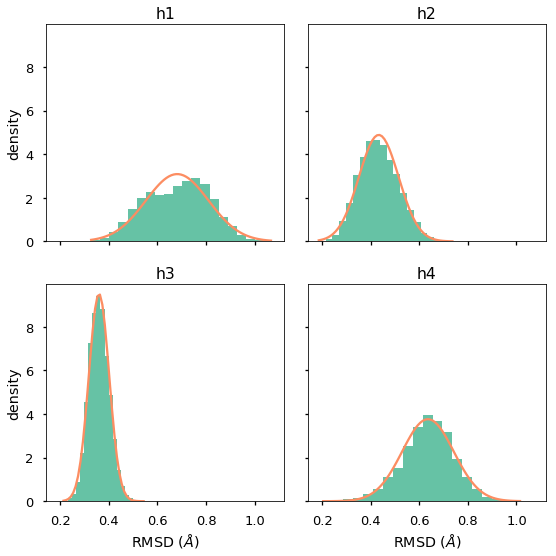

In [106]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(8,8)
j = 0; k = 0;
for i in range(4):
    plot_everything(run_07_colvars['r%d' % (i+1)], ax[k,j])
    ax[k,j].set_title('h%d' % (i+1))
    #ax[k,j].hist(run_07_colvars['r' + str(i + 1)], bins = 20, density = True)
    j += 1
    if j == 2 :
        j = 0
        k = 1
ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('RMSD ($\AA$)')
ax[1,1].set_xlabel('RMSD ($\AA$)')
fig.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/hist_rmsd_helix_run07.png', dpi=300)
plt.show()

run_0


In [31]:
run_07_colvars[['r1', 'r2', 'r3', 'r4']].describe()

,r1,r2,r3,r4
count,10001.000000,10001.000000,10001.000000,10001.000000
mean,0.681605,0.433314,0.359840,0.635622
std,0.129148,0.081628,0.041931,0.106020
min,0.327414,0.186409,0.213567,0.204612
25%,0.579414,0.373930,0.330302,0.569880
50%,0.690970,0.429092,0.358617,0.640454
75%,0.779915,0.489389,0.387532,0.707143
max,1.076935,0.745335,0.551257,1.022546


This is pretty, but I should also check it using prody to ensure robustness

In [133]:
ligA_psf = pdy.parsePSF('F:DM/run2/metadm/ligA/ligA_bb.psf')
ligA_dcd = pdy.DCDFile('F:DM/run2/metadm/ligA/wtmetamd/run_07/run_07_nw.dcd')
selection = '(resnum 3 to 16 or resnum 26 to 31 or resnum 43 to 53) and ca'
sel_h1 = '(resnum 3 to 20) and ca'
sel_h2 = '(resnum 25 to 38) and ca'
sel_h3 = '(resnum 43 to 53) and ca'
sel_h4 = '(resnum 64 to 73) and ca'
selection = sel_h1 + ' or ' + sel_h2 + ' or ' + sel_h3 + ' or ' + sel_h4
ligA_dcd.link(ligA_psf)

In [134]:
initial_structure = pdy.parsePDB(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/reference_helix_rmsd.pdb'
)
initial_h1 = initial_structure.select(sel_h1).getCoords()
initial_h2 = initial_structure.select(sel_h2).getCoords()
initial_h3 = initial_structure.select(sel_h3).getCoords()
initial_h4 = initial_structure.select(sel_h4).getCoords()

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


In [135]:
rg      = np.zeros(250, dtype='float64')
rmsd_h1 = np.zeros(250, dtype='float64')
rmsd_h2 = np.zeros(250, dtype='float64')
rmsd_h3 = np.zeros(250, dtype='float64')
rmsd_h4 = np.zeros(250, dtype='float64')
for i, frm in enumerate(ligA_dcd):    
    
    at = frm.getAtoms().select(selection)
    rg[i] = pdy.calcGyradius(at)
    
    h1_select = frm.getAtoms().select(sel_h1).getCoords()
    h2_select = frm.getAtoms().select(sel_h2).getCoords()
    h3_select = frm.getAtoms().select(sel_h3).getCoords()
    h4_select = frm.getAtoms().select(sel_h4).getCoords()
    
    rot_h1, _ = pdy.superpose(h1_select, initial_h1)
    rot_h2, _ = pdy.superpose(h2_select, initial_h2)
    rot_h3, _ = pdy.superpose(h3_select, initial_h3)
    rot_h4, _ = pdy.superpose(h4_select, initial_h4)
    
    rmsd_h1[i] = pdy.calcRMSD(initial_h1, rot_h1)
    rmsd_h2[i] = pdy.calcRMSD(initial_h2, rot_h2)
    rmsd_h3[i] = pdy.calcRMSD(initial_h3, rot_h3)
    rmsd_h4[i] = pdy.calcRMSD(initial_h4, rot_h4)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


In [136]:
run_07_rmsd = pd.DataFrame.from_items(
    [
        ('H1', rmsd_h1),
        ('H2', rmsd_h2),
        ('H3', rmsd_h3),
        ('H4', rmsd_h4),
    ]
)

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


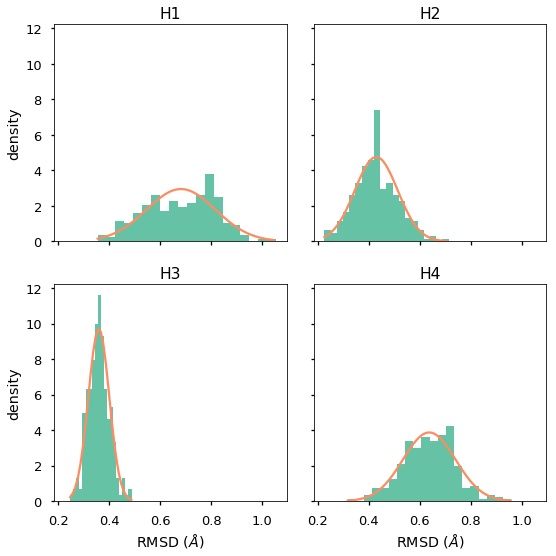

In [137]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(8,8)
j = 0; k = 0;
for i in range(4):
    plot_everything(run_07_rmsd['H%d' % (i+1)], ax[k,j])
    ax[k,j].set_title('H%d' % (i+1))
    #ax[k,j].hist(run_07_colvars['r' + str(i + 1)], bins = 20, density = True)
    j += 1
    if j == 2 :
        j = 0
        k = 1
ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('RMSD ($\AA$)')
ax[1,1].set_xlabel('RMSD ($\AA$)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/hist_rmsd_adhoc_helix_run07.png')
plt.show()

In [138]:
run_07_rmsd.describe()

,H1,H2,H3,H4
count,250.000000,250.000000,250.000000,250.000000
mean,0.681368,0.429686,0.359057,0.637564
std,0.135254,0.083855,0.041080,0.103059
min,0.354418,0.226293,0.246679,0.317241
25%,0.576548,0.375047,0.331168,0.566926
50%,0.696103,0.424839,0.358018,0.639866
75%,0.788387,0.480210,0.382652,0.712876
max,1.054186,0.713365,0.487417,0.959892


They both seem quite similar. Now I will represent the force applied

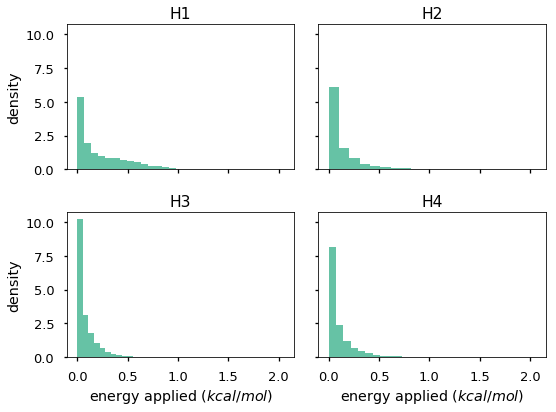

In [139]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(8,6)
j = 0; k = 0;
for i in range(4):
    ax[k,j].hist(run_07_colvars['e%d' % (i+1)], bins = 20, density=True)
    ax[k,j].set_title('H%d' % (i+1))
    #ax[k,j].set_yscale('log')
    #ax[k,j].set_yscale('log')
    #ax[k,j].hist(run_07_colvars['r' + str(i + 1)], bins = 20, density = True)
    j += 1
    if j == 2 :
        j = 0
        k = 1
#plt.xscale('log')
ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')

ax[1,0].set_xlabel('energy applied ($kcal/mol$)')
ax[1,1].set_xlabel('energy applied ($kcal/mol$)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/hist_energy_rmsd.png', dpi=300)

plt.show()

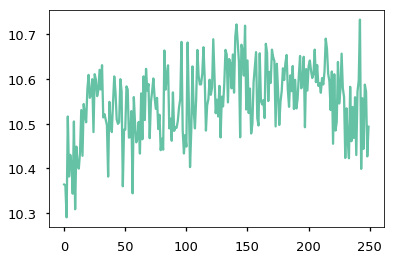

In [141]:
fig, ax = plt.subplots(1)
ax.plot(rg)
plt.show()

In [149]:
pdb = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/input/deepview_open.pdb')


In [150]:
hhh = pdb.select(selection)
pdy.calcGyradius(hhh)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


13.93444724519749

## Analyzing Rg metadynamics + RMSD harmonic bias

In [2]:
run_08_colvars = pd.read_table( 
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_08/run_08.colvars', 
    sep="\s+", comment='#', header = None
)
run_08_colvars.columns = ['step', 'r1','r2', 'r3', 'r4','rg','e1', 'e2', 'e3', 'e4']
run_08_colvars['step'] -= 55000
run_08_colvars[:10]

,step,r1,r2,r3,r4,rg,e1,e2,e3,e4
0,0,0.744587,0.233145,0.237550,0.399033,10.527459,0.057467,0.479555,0.771505,0.330574
1,500,0.705447,0.310982,0.334885,0.326153,10.516235,0.107772,0.136493,0.077384,0.613812
2,1000,0.633142,0.395976,0.268443,0.397707,10.486145,0.241959,0.000279,0.473161,0.334951
3,1500,0.674844,0.353276,0.278903,0.380634,10.436659,0.158031,0.037604,0.388587,0.393873
4,2000,0.648824,0.297404,0.315007,0.347593,10.465264,0.208308,0.181308,0.160599,0.521460
5,2500,0.934303,0.319381,0.306996,0.341651,10.424943,0.035932,0.111952,0.202630,0.546300
6,3000,0.791048,0.297025,0.385683,0.432247,10.354039,0.018115,0.182653,0.001228,0.230335
7,3500,0.551550,0.437171,0.339584,0.373955,10.309232,0.457672,0.023800,0.062103,0.418224
8,4000,0.499585,0.388756,0.312475,0.414825,10.271490,0.630590,0.002178,0.173355,0.280662
9,4500,0.445504,0.394094,0.307463,0.312991,10.356429,0.839917,0.000601,0.200044,0.674230


In [3]:
run_08_colvars[['r1', 'r2', 'r3', 'r4', 'rg']].describe()

,r1,r2,r3,r4,rg
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,0.877571,0.378728,0.359049,0.644268,10.625553
std,0.159190,0.075180,0.044136,0.111708,0.300335
min,0.284537,0.193724,0.203647,0.167228,9.959549
25%,0.799215,0.324079,0.329645,0.571761,10.400362
50%,0.875295,0.371924,0.357773,0.643260,10.601036
75%,0.975253,0.425599,0.386477,0.716393,10.822869
max,1.481689,0.759319,0.548479,1.224875,11.511738


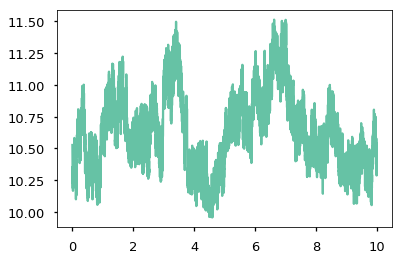

In [4]:
fig, ax = plt.subplots(1)
ax.plot(run_08_colvars['step'] * (2e-6), run_08_colvars['rg'])
plt.show()

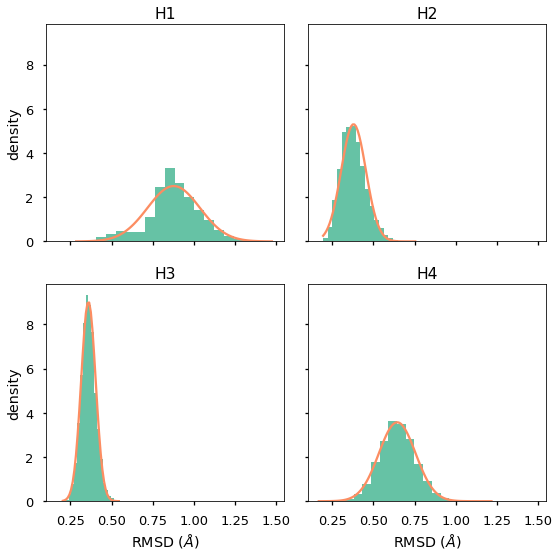

In [29]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(8,8)
j = 0; k = 0;
for i in range(4):
    plot_everything(run_08_colvars['r%d' % (i+1)], ax[k,j])
    ax[k,j].set_title('H%d' % (i+1))
    #ax[k,j].hist(run_07_colvars['r' + str(i + 1)], bins = 20, density = True)
    j += 1
    if j == 2 :
        j = 0
        k = 1
ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('RMSD ($\AA$)')
ax[1,1].set_xlabel('RMSD ($\AA$)')
plt.tight_layout()
plt.show()

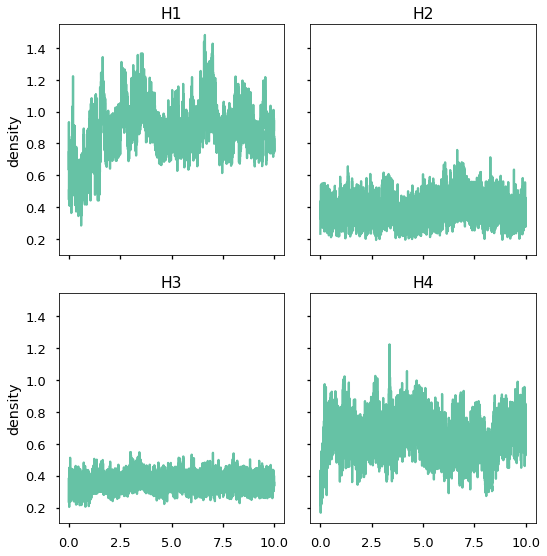

In [30]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_size_inches(8,8)
j = 0; k = 0;
for i in range(4):
    ax[k,j].plot(run_08_colvars['step'] * (2e-6), run_08_colvars['r%d' % (i+1)])
    ax[k,j].set_title('H%d' % (i+1))
    #ax[k,j].hist(run_07_colvars['r' + str(i + 1)], bins = 20, density = True)
    j += 1
    if j == 2 :
        j = 0
        k = 1
ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')
#ax[1,0].set_xlabel('RMSD ($\AA$)')
#ax[1,1].set_xlabel('RMSD ($\AA$)')
plt.tight_layout()
plt.show()

In [15]:
run_08_hills = pd.read_table(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_08/run_08.hills', 
    sep ="\s+", header= None
)
run_08_hills.columns = ['step', 'Rg', 'width', 'height']
Rg,E = gaussian_sum(run_08_hills['height'], run_08_hills['width'], run_08_hills['Rg'], 0.1)

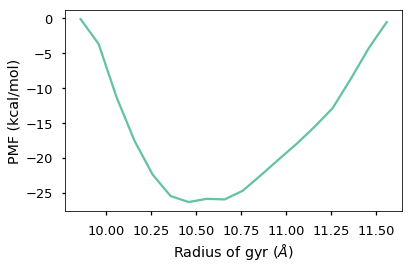

In [33]:
E_c = E * (4500.0 / (298.0 + 4500.0))
E_c -= E_c.min()
fig, ax = plt.subplots(1)
ax.plot(Rg, -E)
ax.set_ylabel('PMF (kcal/mol)')
ax.set_xlabel('Radius of gyr ($\AA$)')
fig.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/metadynamics_4500_pmf.png')
plt.show()

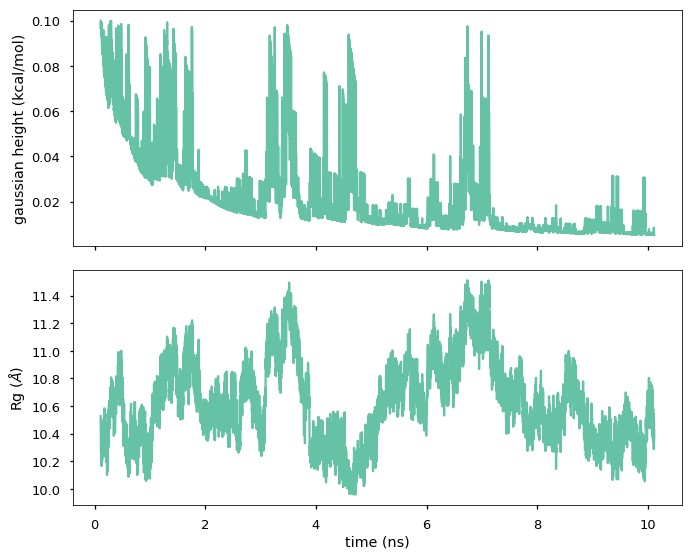

In [31]:
fig, ax = plt.subplots(2,1, sharex = True)
fig.set_size_inches(10,8)
ax[0].plot(run_08_hills['step'] * (2e-6), run_08_hills['height'])
ax[1].plot(run_08_hills['step'] * (2e-6), run_08_hills['Rg'])
ax[0].set_ylabel('gaussian height (kcal/mol)')
ax[1].set_ylabel('Rg ($\AA$)')
ax[1].set_xlabel('time (ns)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/metadynamics_4500_ts.png', dpi=300)
plt.show()

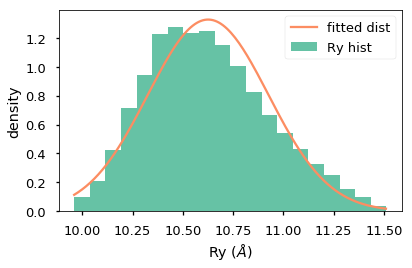

In [34]:
fig, ax = plt.subplots(1)
ax.hist(run_08_hills['Rg'], density = True, bins=20, label='Ry hist')
x, y = norm_distribution(
    run_08_hills['Rg'].mean(), 
    run_08_hills['Rg'].var(), 
    [run_08_hills['Rg'].min(), run_08_hills['Rg'].max(), 0.01]
)
ax.plot(x, y, label='fitted dist')
ax.set_xlabel('Ry ($\AA$)')
ax.set_ylabel('density')
ax.legend()
fig.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/opening/run_08_hist_gyr_radius.png', dpi=300)
plt.show()

## Analysis of LTP - tunnel ligA and ligB - META06

In [22]:
hills_A, colvars_A, pmf_A = read_metadynamics_output(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06/run_06'
)

[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06/run_06.hills
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06/run_06.colvars
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06/run_06.pmf


In [23]:
hills_B, colvars_B, pmf_B = read_metadynamics_output(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06/run_06'
)

[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06/run_06.hills
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06/run_06.colvars
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06/run_06.pmf


In [24]:
def plot_deposition(hhh, ax):
    hist = ax.hexbin(hhh['z'], hhh['height'], bins='log', cmap='nipy_spectral')
    zmin = hhh['z'].min()
    zmax = hhh['z'].max()
    hmin = hhh['height'].min()
    hmax = hhh['height'].max()
    #bar  = ax.colorbar(hist)
    #bar.set_label('$\log_{10}$ counts')
    ax.axis([zmin, zmax, hmin, hmax])
    ax.set_xlabel('distance $\AA$')
    ax.set_ylabel('gaussian height (kcal/mol)')
    #ax.set_yscale('log')
    #plt.show()

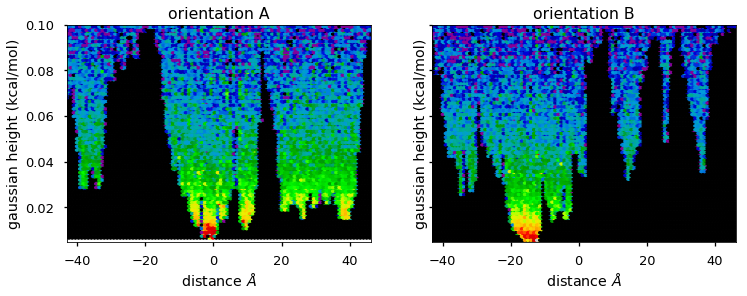

In [31]:
fig, ax = plt.subplots(1,2, sharex = True, sharey=True)
fig.set_size_inches(12,4)
plot_deposition(hills_A, ax[0])
plot_deposition(hills_B, ax[1])
ax[0].set_title('orientation A')
ax[1].set_title('orientation B')
plt.show()

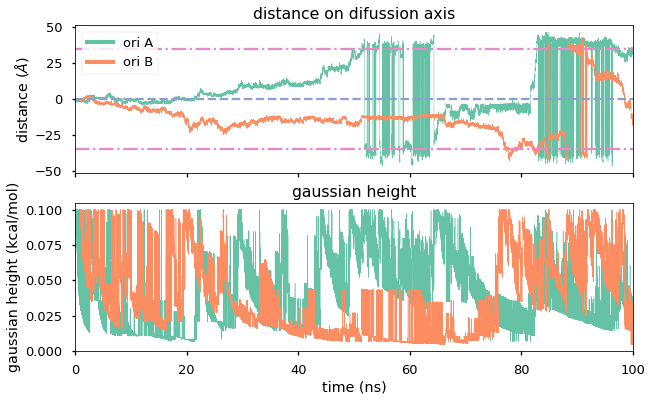

In [65]:
fig, ax = plt.subplots(2,1 , sharex = True, sharey = False)
fig.set_size_inches(10,6)
ax[0].plot(hills_A['time']* (2e-6), hills_A['z'], label = 'ori A', linewidth=0.5)
ax[0].plot(hills_B['time']* (2e-6), hills_B['z'], label = 'ori B', linewidth=0.5)
ax[1].plot(hills_A['time']* (2e-6), hills_A['height'], label = 'ori A', linewidth=0.5)
ax[1].plot(hills_B['time']* (2e-6), hills_B['height'], label = 'ori B', linewidth=0.5)
ax[0].set_xlim((0,100))
ax[1].set_xlabel('time (ns)')
ax[0].set_ylabel('distance ($\AA$)')
ax[1].set_ylabel('gaussian height (kcal/mol)')
leg = ax[0].legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
ax[0].axhline(0.0, linestyle='--', color = sns.color_palette('Set2')[2])
ax[0].axhline(35.0, linestyle='-.', color = sns.color_palette('Set2')[3])
ax[0].axhline(-35.0, linestyle='-.', color = sns.color_palette('Set2')[3])
ax[0].set_title('distance on difussion axis')
ax[1].set_title('gaussian height')
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/tunnel/whole_traj_ts.png', dpi=300)
plt.show()

In [32]:
hills_A.describe()

,time,z,width,height
count,1.155850e+05,115585.000000,1.155850e+05,115585.000000
mean,2.889600e+07,9.277183,1.600000e-01,0.040273
std,1.668333e+07,20.902017,1.254557e-13,0.024127
min,0.000000e+00,-47.150517,1.600000e-01,0.006431
25%,1.444800e+07,-2.597963,1.600000e-01,0.021438
50%,2.889600e+07,8.218756,1.600000e-01,0.033740
75%,4.334400e+07,26.972472,1.600000e-01,0.055695
max,5.779200e+07,46.885873,1.600000e-01,0.100000


In [102]:
ZA,EA = gaussian_sum(hills_A['height'].values, hills_A['width'].values,hills_A['z'].values, spacing=0.1)
ZB,EB = gaussian_sum(hills_B['height'].values, hills_B['width'].values,hills_B['z'].values, spacing=0.1)

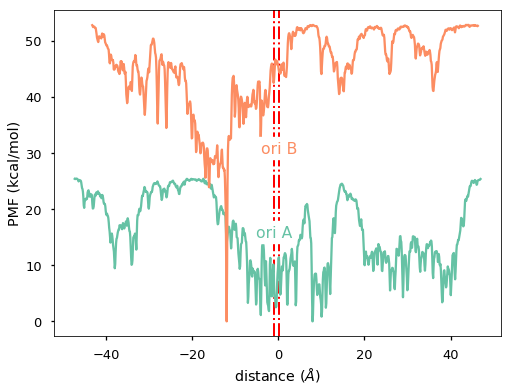

In [106]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
bias_factor =  (4500.0 / (298.0 + 4500.0))
EA_c = -EA * bias_factor 
EA_c -= EA_c.min()
EB_c = -EB * bias_factor 
EB_c -= EB_c.min()
#E_cA = -EA * bias_factor 
#E_cA -= E_cA.min()
ax.axvline(-0.88, linewidth = 2 , linestyle = '-.', color = 'red')
ax.text(
    -0.88, 15, 'ori A', 
    horizontalalignment = 'center', 
    backgroundcolor = 'white', color = sns.color_palette('Set2')[0]
)
ax.axvline(0.22, linewidth = 2 , linestyle = '-.', color = 'red')
ax.text(
    0.22, 30, 'ori B', 
    horizontalalignment = 'center', 
    backgroundcolor = 'white', color = sns.color_palette('Set2')[1])
ax.plot(ZA,EA_c)
ax.plot(ZB,EB_c)
#plt.plot(pmf_2['z'], pmf_2['PMF'])
ax.set_ylabel('PMF (kcal/mol)')
ax.set_xlabel('distance ($\AA$)')
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/tunnel/pmf_100ns.png', dpi=300)
plt.show()

In [78]:
hills_A_subset = hills_A[:40000]
hills_B_subset = hills_B[:40000]

In [111]:
ZA,EA = gaussian_sum(
    hills_A_subset['height'].values, 
    hills_A_subset['width'].values,
    hills_A_subset['z'].values, 
    spacing=0.1
)
ZB,EB = gaussian_sum(
    hills_B_subset['height'].values, 
    hills_B_subset['width'].values,
    hills_B_subset['z'].values, 
    spacing=0.1
)

bias_factor =  (4500.0 / (298.0 + 4500.0))
EA_c = -EA * bias_factor 
EA_c -= EA_c.min()
EB_c = -EB * bias_factor 
EB_c -= EB_c.min()
#E_cA = -EA * bias_factor 
#E_cA -= E_cA.min()


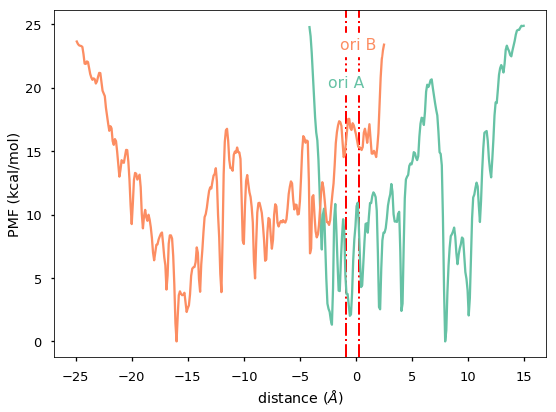

In [101]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.axvline(-0.88, linewidth = 2 , linestyle = '-.', color = 'red')
ax.text(
    -0.88, 20, 'ori A', 
    horizontalalignment = 'center', 
    backgroundcolor = 'white', color = sns.color_palette('Set2')[0]
)
ax.axvline(0.22, linewidth = 2 , linestyle = '-.', color = 'red')
ax.text(
    0.22, 23, 'ori B', 
    horizontalalignment = 'center', 
    backgroundcolor = 'white', color = sns.color_palette('Set2')[1])
#plt.plot(pmf_2['z'], pmf_2['PMF'])
ax.plot(ZA,EA_c)
ax.plot(ZB,EB_c)
ax.set_ylabel('PMF (kcal/mol)')
ax.set_xlabel('distance ($\AA$)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/tunnel/pmf_40ns.png', dpi=300)
plt.show()

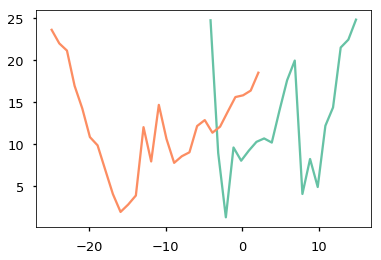

In [112]:
fig, ax = plt.subplots(1)
ax.plot(ZA[::10],EA_c[::10])
ax.plot(ZB[::10],EB_c[::10])
plt.show()

In [12]:
def soften(x, windowsize = 10) :
    y = np.zeros(x.size)
    for i in range(5):
        y[i] = np.mean(x[:i+5])
        y[-(i+1)] = np.mean(x[-i-5:])
    for i in range(5, x.size - 5):
        y[i] = np.mean(x[i-5:i+5])
    return y

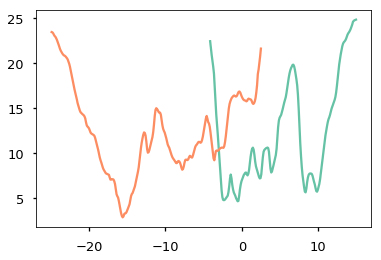

In [131]:
fig, ax = plt.subplots(1)
soften_A = soften(EA_c, windowsize=500)
soften_B = soften(EB_c, windowsize=500)
#ax.plot(ZA,EA_c)
ax.plot(ZA,soften_A)
ax.plot(ZB,soften_B)
plt.show()


In [140]:
from scipy.signal import argrelextrema
XA = argrelextrema(-soften_A, np.less)[0]
XB = argrelextrema(-soften_B, np.less)[0]

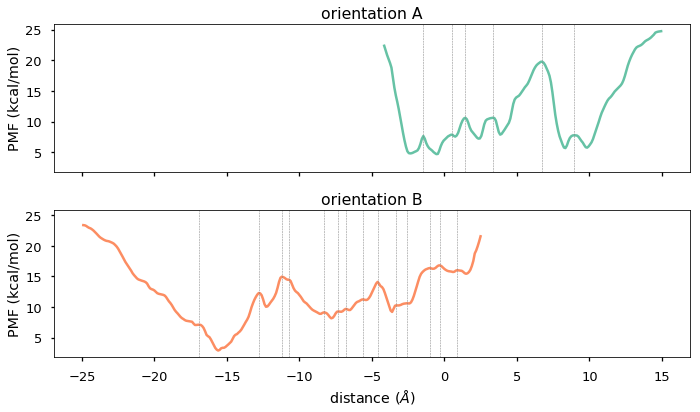

In [156]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
fig.set_size_inches(10,6)
soften_A = soften(EA_c, windowsize=1000)
soften_B = soften(EB_c, windowsize=1000)
#ax.plot(ZA,EA_c)
ax[0].plot(ZA,soften_A,color = sns.color_palette('Set2')[0], linewidth=2.5)
ax[1].plot(ZB,soften_B, color = sns.color_palette('Set2')[1], linewidth=2.5)
for i in range(XA.size):
    ax[0].axvline(ZA[XA[i]], linewidth=0.5, linestyle='--', color='gray')
for i in range(XB.size):
    ax[1].axvline(ZB[XB[i]], linewidth=0.5, linestyle='--', color='gray')
ax[0].set_ylabel('PMF (kcal/mol)')
ax[1].set_ylabel('PMF (kcal/mol)')
ax[1].set_xlabel('distance ($\AA$)')
ax[0].set_title('orientation A')
ax[1].set_title('orientation B')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/tunnel/energetic_landscapes_basins_40ns.png', dpi=300)
plt.show()


In [5]:
hills_A, colvars_A, pmf_A = read_metadynamics_output(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06_02/run_06_02'
)
hills_B, colvars_B, pmf_B = read_metadynamics_output(
    'C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06_02/run_06_02'
)

[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06_02/run_06_02.hills
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06_02/run_06_02.colvars
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06_02/run_06_02.pmf
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06_02/run_06_02.hills
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06_02/run_06_02.colvars
[METADYN] reading C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06_02/run_06_02.pmf


In [8]:
ZA,EA = gaussian_sum(hills_A['height'].values, hills_A['width'].values,hills_A['z'].values, spacing=0.1)
ZB,EB = gaussian_sum(hills_B['height'].values, hills_B['width'].values,hills_B['z'].values, spacing=0.1)

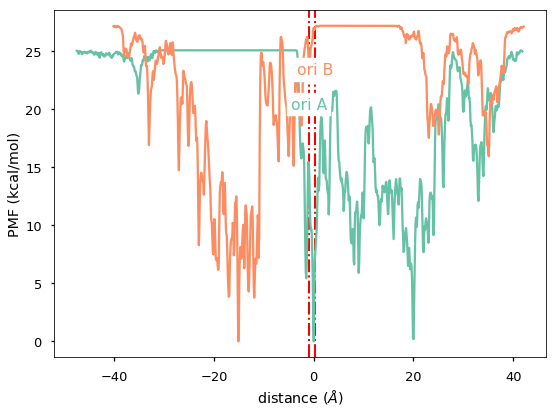

In [11]:
EA_c = -EA * 4500.0 /(298.0 + 4500.0)
EB_c = -EB * 4500.0 /(298.0 + 4500.0)
EA_c -= EA_c.min()
EB_c -= EB_c.min()
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.axvline(-0.88, linewidth = 2 , linestyle = '-.', color = 'red')
ax.text(
    -0.88, 20, 'ori A', 
    horizontalalignment = 'center', 
    backgroundcolor = 'white', color = sns.color_palette('Set2')[0]
)
ax.axvline(0.22, linewidth = 2 , linestyle = '-.', color = 'red')
ax.text(
    0.22, 23, 'ori B', 
    horizontalalignment = 'center', 
    backgroundcolor = 'white', color = sns.color_palette('Set2')[1])
#plt.plot(pmf_2['z'], pmf_2['PMF'])
ax.plot(ZA,EA_c)
ax.plot(ZB,EB_c)
ax.set_ylabel('PMF (kcal/mol)')
ax.set_xlabel('distance ($\AA$)')
plt.tight_layout()
#plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/tunnel/pmf_40ns.png', dpi=300)
plt.show()

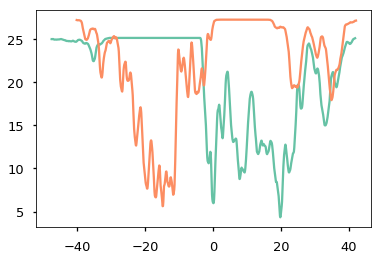

In [19]:
fig, ax = plt.subplots(1)
soften_A = soften(EA_c, windowsize=1500)
soften_B = soften(EB_c, windowsize=1500)
#ax.plot(ZA,EA_c)
ax.plot(ZA,soften_A)
ax.plot(ZB,soften_B)
plt.show()


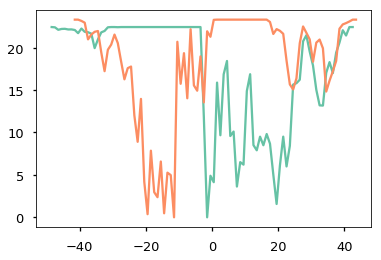

In [18]:
plt.plot(pmf_A['z'], pmf_A['PMF'])
plt.plot(pmf_B['z'], pmf_B['PMF'])
plt.show()

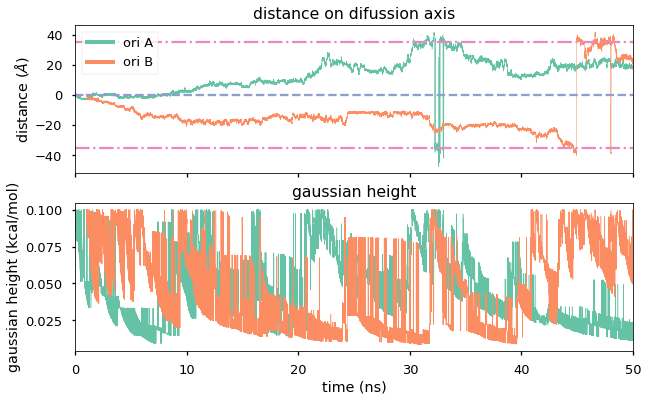

In [21]:
fig, ax = plt.subplots(2,1 , sharex = True, sharey = False)
fig.set_size_inches(10,6)
ax[0].plot(hills_A['time']* (2e-6), hills_A['z'], label = 'ori A', linewidth=0.5)
ax[0].plot(hills_B['time']* (2e-6), hills_B['z'], label = 'ori B', linewidth=0.5)
ax[1].plot(hills_A['time']* (2e-6), hills_A['height'], label = 'ori A', linewidth=0.5)
ax[1].plot(hills_B['time']* (2e-6), hills_B['height'], label = 'ori B', linewidth=0.5)
ax[0].set_xlim((0,50))
ax[1].set_xlabel('time (ns)')
ax[0].set_ylabel('distance ($\AA$)')
ax[1].set_ylabel('gaussian height (kcal/mol)')
leg = ax[0].legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
ax[0].axhline(0.0, linestyle='--', color = sns.color_palette('Set2')[2])
ax[0].axhline(35.0, linestyle='-.', color = sns.color_palette('Set2')[3])
ax[0].axhline(-35.0, linestyle='-.', color = sns.color_palette('Set2')[3])
ax[0].set_title('distance on difussion axis')
ax[1].set_title('gaussian height')
#plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/tunnel/whole_traj_ts.png', dpi=300)
plt.show()

## Saposin opening analysis

In [82]:
sapA_open_psf = pdy.parsePSF('F:DM/run2/metadm/sapoA/1Aopen-4DDJ_nowater.psf')
sapA_open_dcd = pdy.DCDFile('F:DM/run2/metadm/sapoA/sapoA_processed.dcd')
reference_structure = pdy.parsePDB('F:/DM/run2/metadm/sapoA/1Aopen-4DDJ_charmm_gui.pdb')
selection = '((resnum 3 to 19) or (resnum 23 to 35) or (resnum 43 to 65) or (resnum 70 to 75)) and ca'
sel_h1 = '(resnum 3 to 15) and ca'
sel_h2 = '(resnum 23 to 35) and ca'
sel_h3 = '(resnum 43 to 53) and ca'
sel_h4 = '(resnum 53 to 64) and ca'
sel_h5 = '(resnum 70 to 75) and ca'
sapA_open_dcd.link(sapA_open_psf)
sapA_open_dcd.setCoords(reference_structure)

In [76]:

initial_h1 = reference_structure.select(sel_h1).getCoords()
initial_h2 = reference_structure.select(sel_h2).getCoords()
initial_h3 = reference_structure.select(sel_h3).getCoords()
initial_h4 = reference_structure.select(sel_h4).getCoords()
initial_h5 = reference_structure.select(sel_h5).getCoords()

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


In [77]:
rg = np.zeros(2500, dtype='float64')
rmsd_h1 = np.zeros(2500, dtype='float64')
rmsd_h2 = np.zeros(2500, dtype='float64')
rmsd_h3 = np.zeros(2500, dtype='float64')
rmsd_h4 = np.zeros(2500, dtype='float64')
rmsd_h5 = np.zeros(2500, dtype='float64')
for i, frm in enumerate(sapA_open_dcd):
    
    at = frm.getAtoms().select(selection)
    rg[i] = pdy.calcGyradius(at)
    
    h1_select = frm.getAtoms().select(sel_h1).getCoords()
    h2_select = frm.getAtoms().select(sel_h2).getCoords()
    h3_select = frm.getAtoms().select(sel_h3).getCoords()
    h4_select = frm.getAtoms().select(sel_h4).getCoords()
    h5_select = frm.getAtoms().select(sel_h5).getCoords()
    
    rot_h1, _ = pdy.superpose(h1_select, initial_h1)
    rot_h2, _ = pdy.superpose(h2_select, initial_h2)
    rot_h3, _ = pdy.superpose(h3_select, initial_h3)
    rot_h4, _ = pdy.superpose(h4_select, initial_h4)
    rot_h5, _ = pdy.superpose(h5_select, initial_h5)
    
    rmsd_h1[i] = pdy.calcRMSD(initial_h1, rot_h1)
    rmsd_h2[i] = pdy.calcRMSD(initial_h2, rot_h2)
    rmsd_h3[i] = pdy.calcRMSD(initial_h3, rot_h3)
    rmsd_h4[i] = pdy.calcRMSD(initial_h4, rot_h4)
    rmsd_h5[i] = pdy.calcRMSD(initial_h5, rot_h5)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


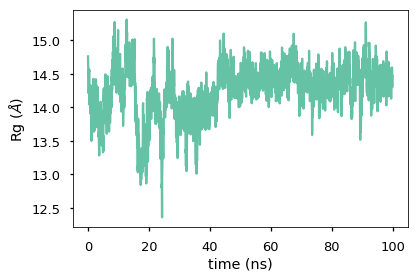

In [78]:
fig, ax = plt.subplots(1)
ax.plot(np.arange(0,1e2, 4e-2), rg)
ax.set_ylabel('Rg ($\AA$)')
ax.set_xlabel('time (ns)')
plt.show()

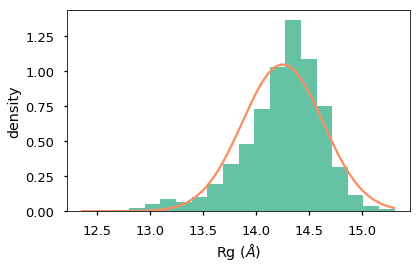

In [79]:
fig, ax = plt.subplots(1)
x, y = norm_distribution(np.mean(rg), np.var(rg), [rg.min(), rg.max(), 0.01])
ax.hist(rg, bins= 20, density = True, label = 'histogram')
ax.plot(x, y, label='fitted dist')
ax.set_ylabel('density')
ax.set_xlabel('Rg ($\AA$)')
fig.tight_layout()
plt.show()

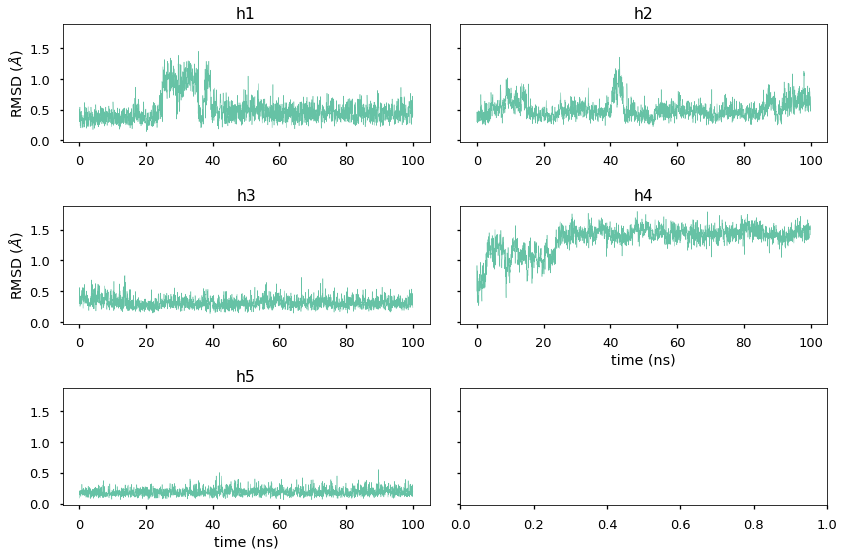

In [80]:
fig, ax = plt.subplots(3,2, sharey=True)
fig.set_size_inches(12,8)
ax[0,0].plot(np.arange(0, 1e2, 0.04), rmsd_h1, linewidth=0.5)
ax[0,0].set_title('h1')
ax[0,1].plot(np.arange(0, 1e2, 0.04), rmsd_h2, linewidth=0.5)
ax[0,1].set_title('h2')
ax[1,0].plot(np.arange(0, 1e2, 0.04), rmsd_h3, linewidth=0.5)
ax[1,0].set_title('h3')
ax[1,1].plot(np.arange(0, 1e2, 0.04), rmsd_h4, linewidth=0.5)
ax[1,1].set_title('h4')
ax[2,0].plot(np.arange(0, 1e2, 0.04), rmsd_h5, linewidth=0.5)
ax[2,0].set_title('h5')
ax[1,0].set_ylabel('RMSD ($\AA$)')
ax[0,0].set_ylabel('RMSD ($\AA$)')
ax[2,0].set_xlabel('time (ns)')
ax[1,1].set_xlabel('time (ns)')
plt.tight_layout()
plt.show()

In [93]:
sapA_open_psf = pdy.parsePSF('F:DM/run2/metadm/sapoA/1Aopen-4DDJ_nowater.psf')
sapA_open_dcd = pdy.parseDCD('F:DM/run2/metadm/sapoA/sapoA_processed.dcd')
reference_structure = pdy.parsePDB('F:/DM/run2/metadm/sapoA/1Aopen-4DDJ_charmm_gui.pdb')

#sapA_open_dcd.link(sapA_open_psf)
sapA_open_dcd.setAtoms(reference_structure.select('ca'))
sapA_open_dcd.setCoords(reference_structure)

sapA_open_dcd.superpose()
rmsf = sapA_open_dcd.getRMSFs()
hv = reference_structure.getHierView()
resname = ["%3s" % (j) for i,j in enumerate(hv.iterResidues()) if i % 5 == 0]
pos = [i  for i,j in enumerate(hv.iterResidues()) if i % 5 == 0]

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


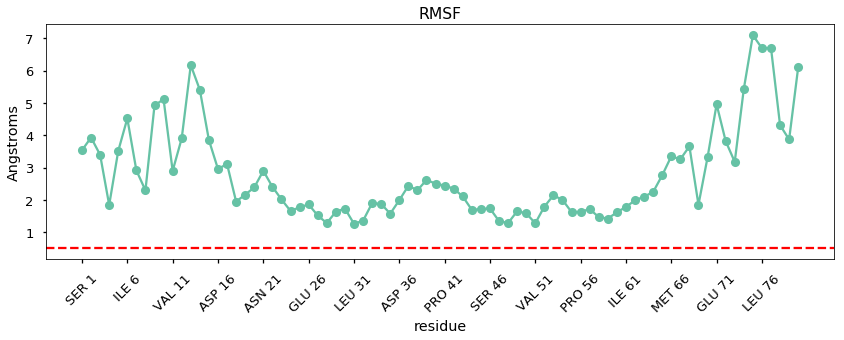

In [95]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12,5)
ax.plot(rmsf, marker = 'o')
ax.set_xticks(pos)
ax.set_xticklabels(resname, rotation=45)
ax.set_title('RMSF')
ax.set_ylabel('Angstroms')
ax.set_xlabel('residue')
ax.axhline(0.5, linestyle='--', color = 'red')
plt.tight_layout()
plt.show()

### Closed

In [9]:
sapA_open_psf = pdy.parsePSF('C:/Users/Bruno/Dropbox/LTP/METAMD/sapoA/closed/input/sapAc_charmm.psf')
sapA_open_dcd = pdy.DCDFile('F:DM/run2/metadm/sapoA/closed/sapAc_md_nw.dcd')
reference_structure = pdy.parsePDB('C:/Users/Bruno/Dropbox/LTP/METAMD/sapoA/closed/input/sapAc_charmm.pdb')
selection = '((resnum 3 to 19) or (resnum 23 to 35) or (resnum 43 to 65) or (resnum 70 to 75)) and ca'
sel_h1 = '(resnum 3 to 15) and ca'
sel_h2 = '(resnum 23 to 35) and ca'
sel_h3 = '(resnum 43 to 53) and ca'
sel_h4 = '(resnum 53 to 64) and ca'
sel_h5 = '(resnum 70 to 75) and ca'
sapA_open_dcd.link(sapA_open_psf)
sapA_open_dcd.setCoords(reference_structure)

In [10]:

initial_h1 = reference_structure.select(sel_h1).getCoords()
initial_h2 = reference_structure.select(sel_h2).getCoords()
initial_h3 = reference_structure.select(sel_h3).getCoords()
initial_h4 = reference_structure.select(sel_h4).getCoords()
initial_h5 = reference_structure.select(sel_h5).getCoords()

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


In [11]:
rg = np.zeros(250, dtype='float64')
rmsd_h1 = np.zeros(250, dtype='float64')
rmsd_h2 = np.zeros(250, dtype='float64')
rmsd_h3 = np.zeros(250, dtype='float64')
rmsd_h4 = np.zeros(250, dtype='float64')
rmsd_h5 = np.zeros(250, dtype='float64')
for i, frm in enumerate(sapA_open_dcd):
    
    at = frm.getAtoms().select(selection)
    rg[i] = pdy.calcGyradius(at)
    
    h1_select = frm.getAtoms().select(sel_h1).getCoords()
    h2_select = frm.getAtoms().select(sel_h2).getCoords()
    h3_select = frm.getAtoms().select(sel_h3).getCoords()
    h4_select = frm.getAtoms().select(sel_h4).getCoords()
    h5_select = frm.getAtoms().select(sel_h5).getCoords()
    
    rot_h1, _ = pdy.superpose(h1_select, initial_h1)
    rot_h2, _ = pdy.superpose(h2_select, initial_h2)
    rot_h3, _ = pdy.superpose(h3_select, initial_h3)
    rot_h4, _ = pdy.superpose(h4_select, initial_h4)
    rot_h5, _ = pdy.superpose(h5_select, initial_h5)
    
    rmsd_h1[i] = pdy.calcRMSD(initial_h1, rot_h1)
    rmsd_h2[i] = pdy.calcRMSD(initial_h2, rot_h2)
    rmsd_h3[i] = pdy.calcRMSD(initial_h3, rot_h3)
    rmsd_h4[i] = pdy.calcRMSD(initial_h4, rot_h4)
    rmsd_h5[i] = pdy.calcRMSD(initial_h5, rot_h5)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


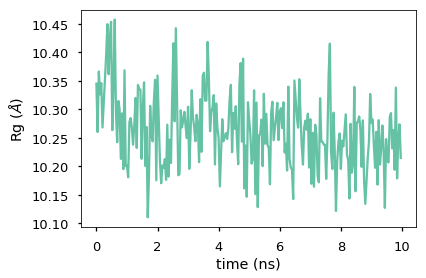

In [12]:
fig, ax = plt.subplots(1)
ax.plot(np.arange(0,1e1, 4e-2), rg)
ax.set_ylabel('Rg ($\AA$)')
ax.set_xlabel('time (ns)')
plt.show()

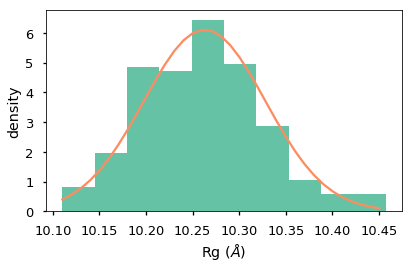

In [17]:
fig, ax = plt.subplots(1)
x, y = norm_distribution(np.mean(rg), np.var(rg), [rg.min(), rg.max(), 0.01])
ax.hist(rg, bins= 10, density = True, label = 'histogram')
ax.plot(x, y, label='fitted dist')
ax.set_ylabel('density')
ax.set_xlabel('Rg ($\AA$)')
fig.tight_layout()
plt.show()

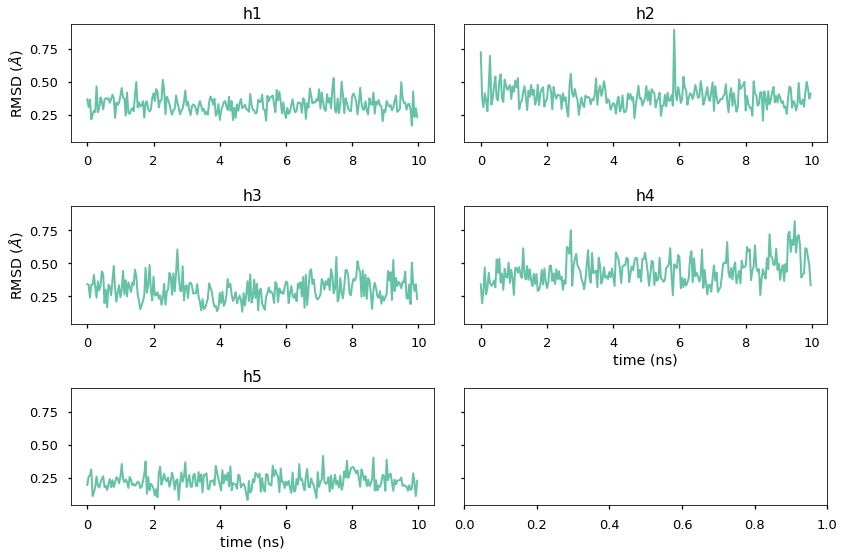

In [21]:
fig, ax = plt.subplots(3,2, sharey=True)
fig.set_size_inches(12,8)
ax[0,0].plot(np.arange(0, 1e1, 0.04), rmsd_h1, linewidth=2)
ax[0,0].set_title('h1')
ax[0,1].plot(np.arange(0, 1e1, 0.04), rmsd_h2, linewidth=2)
ax[0,1].set_title('h2')
ax[1,0].plot(np.arange(0, 1e1, 0.04), rmsd_h3, linewidth=2)
ax[1,0].set_title('h3')
ax[1,1].plot(np.arange(0, 1e1, 0.04), rmsd_h4, linewidth=2)
ax[1,1].set_title('h4')
ax[2,0].plot(np.arange(0, 1e1, 0.04), rmsd_h5, linewidth=2)
ax[2,0].set_title('h5')
ax[1,0].set_ylabel('RMSD ($\AA$)')
ax[0,0].set_ylabel('RMSD ($\AA$)')
ax[2,0].set_xlabel('time (ns)')
ax[1,1].set_xlabel('time (ns)')
plt.tight_layout()
plt.show()

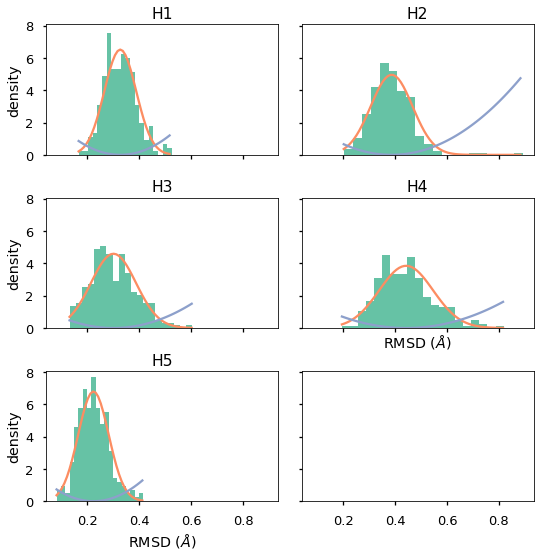

In [25]:
fig, ax = plt.subplots(3,2, sharex=True, sharey=True)
fig.set_size_inches(8,8)
j = 0; k = 0;

plot_everything(rmsd_h1, ax[0,0])
ax[0,0].set_title('H%d' % 1)

plot_everything(rmsd_h2, ax[0,1])
ax[0,1].set_title('H%d' % 2)

plot_everything(rmsd_h3, ax[1,0])
ax[1,0].set_title('H%d' % 3)

plot_everything(rmsd_h4, ax[1,1])
ax[1,1].set_title('H%d' % 4)

plot_everything(rmsd_h5, ax[2,0])
ax[2,0].set_title('H%d' % 5)

ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')
ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('RMSD ($\AA$)')
ax[1,1].set_xlabel('RMSD ($\AA$)')
plt.tight_layout()
plt.show()

## Analysis of the second round of META 06